In [1]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("whitegrid")
from collections import defaultdict
from numpy import mean
from numpy import std
import shap
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display
from scipy import stats
import scipy.stats
import itertools
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [2]:
def run_test(X_train,y_train, model):
    
    # split into train test sets
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
    
    #undersample 
    rus = RandomUnderSampler(random_state=42, replacement=True)
    x_rus, y_rus = rus.fit_resample(X_train, y_train)

    print('original dataset shape:', Counter(y_train))
    print('Resample dataset shape', Counter(y_rus))

   #create the model
    if model == 'Extra Trees':
        clf = ExtraTreesClassifier(n_estimators=1000, random_state=33)
    elif model == 'Random Forest':
        clf = RandomForestClassifier(n_estimators=1000, random_state=33)
    elif model == 'Logistic Regression':
        clf = LogisticRegression(max_iter=10000, solver = 'lbfgs',random_state=33)
        std = StandardScaler()
        std.fit(x_rus)

        #apply

        x_rus = std.transform(x_rus)
        X_test = std.transform(X_test)
    elif model == 'Bayes':
        clf = GaussianNB()
    elif model == 'XGBoost':
        clf = XGBClassifier(use_label_encoder=False, verbosity=0)
        
  
    
    #fit the model on training data 
    clf.fit(x_rus, y_rus)
  
    
    #predict the on the test set
    y_pred = clf.predict(X_test)
    
    #create output of predictions
    predictions = pd.DataFrame(y_pred, columns = ['ouput'])
    predictions["y_true_value"] = y_test.values
    predictions['model'] = model

    
    #calculate test score 
    test_score = accuracy_score(y_test,y_pred)
    
    #calculate precision score
    precision = precision_score(y_test, y_pred, average='binary')
    
    #calculate recall 
    recall = recall_score(y_test, y_pred, average='binary')
    
    #calculate F score
    f_score = f1_score(y_test, y_pred, average='binary')
    
    # predict probabilities
    cl_probs = clf.predict_proba(X_test)
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    
    # keep probabilities for the positive outcome only
    cl_probs = cl_probs[:, 1]
    
    # calculate auc scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    cl_auc = roc_auc_score(y_test, cl_probs)
    
    # summarize auc scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(str(model)+': ROC AUC=%.3f' % (cl_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, cl_probs)
    
    # plot the roc curve for the model
    
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label= str(model))
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    # show the legend
    pyplot.legend()
    
    #titles
    plt.title(str(model)+" ROC Curve")
    
    #save the plt
    plt.savefig(str(model)+'_final_corr.png')
    
    # show the plot
    pyplot.show()

    
    #print confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([ 'interical', 'preictal']); ax.yaxis.set_ticklabels(['interictal', 'preictal']);
    plt.savefig("'Confusion_matrix_' + str(model).png")
    
    print("\nThe Accuracy Score is {}".format(test_score),
         "\nThe Precision Score is {}".format(precision),
         "\nThe Recall Score is {}".format(recall),
         "\nThe F Score is {}".format(f_score))
    
    return predictions

In [9]:
#load training data

train_data = pd.read_csv("train_db3_256_corr.csv")

#drop recording labels for modeling 
cols = ['Recording']
train_df = train_data.drop(cols, axis=1)

X_train = train_df.drop('y', axis=1)
y_train = train_df['y']


original dataset shape: Counter({0.0: 2492, 1.0: 176})
Resample dataset shape Counter({0.0: 176, 1.0: 176})
No Skill: ROC AUC=0.500
Extra Trees: ROC AUC=0.841


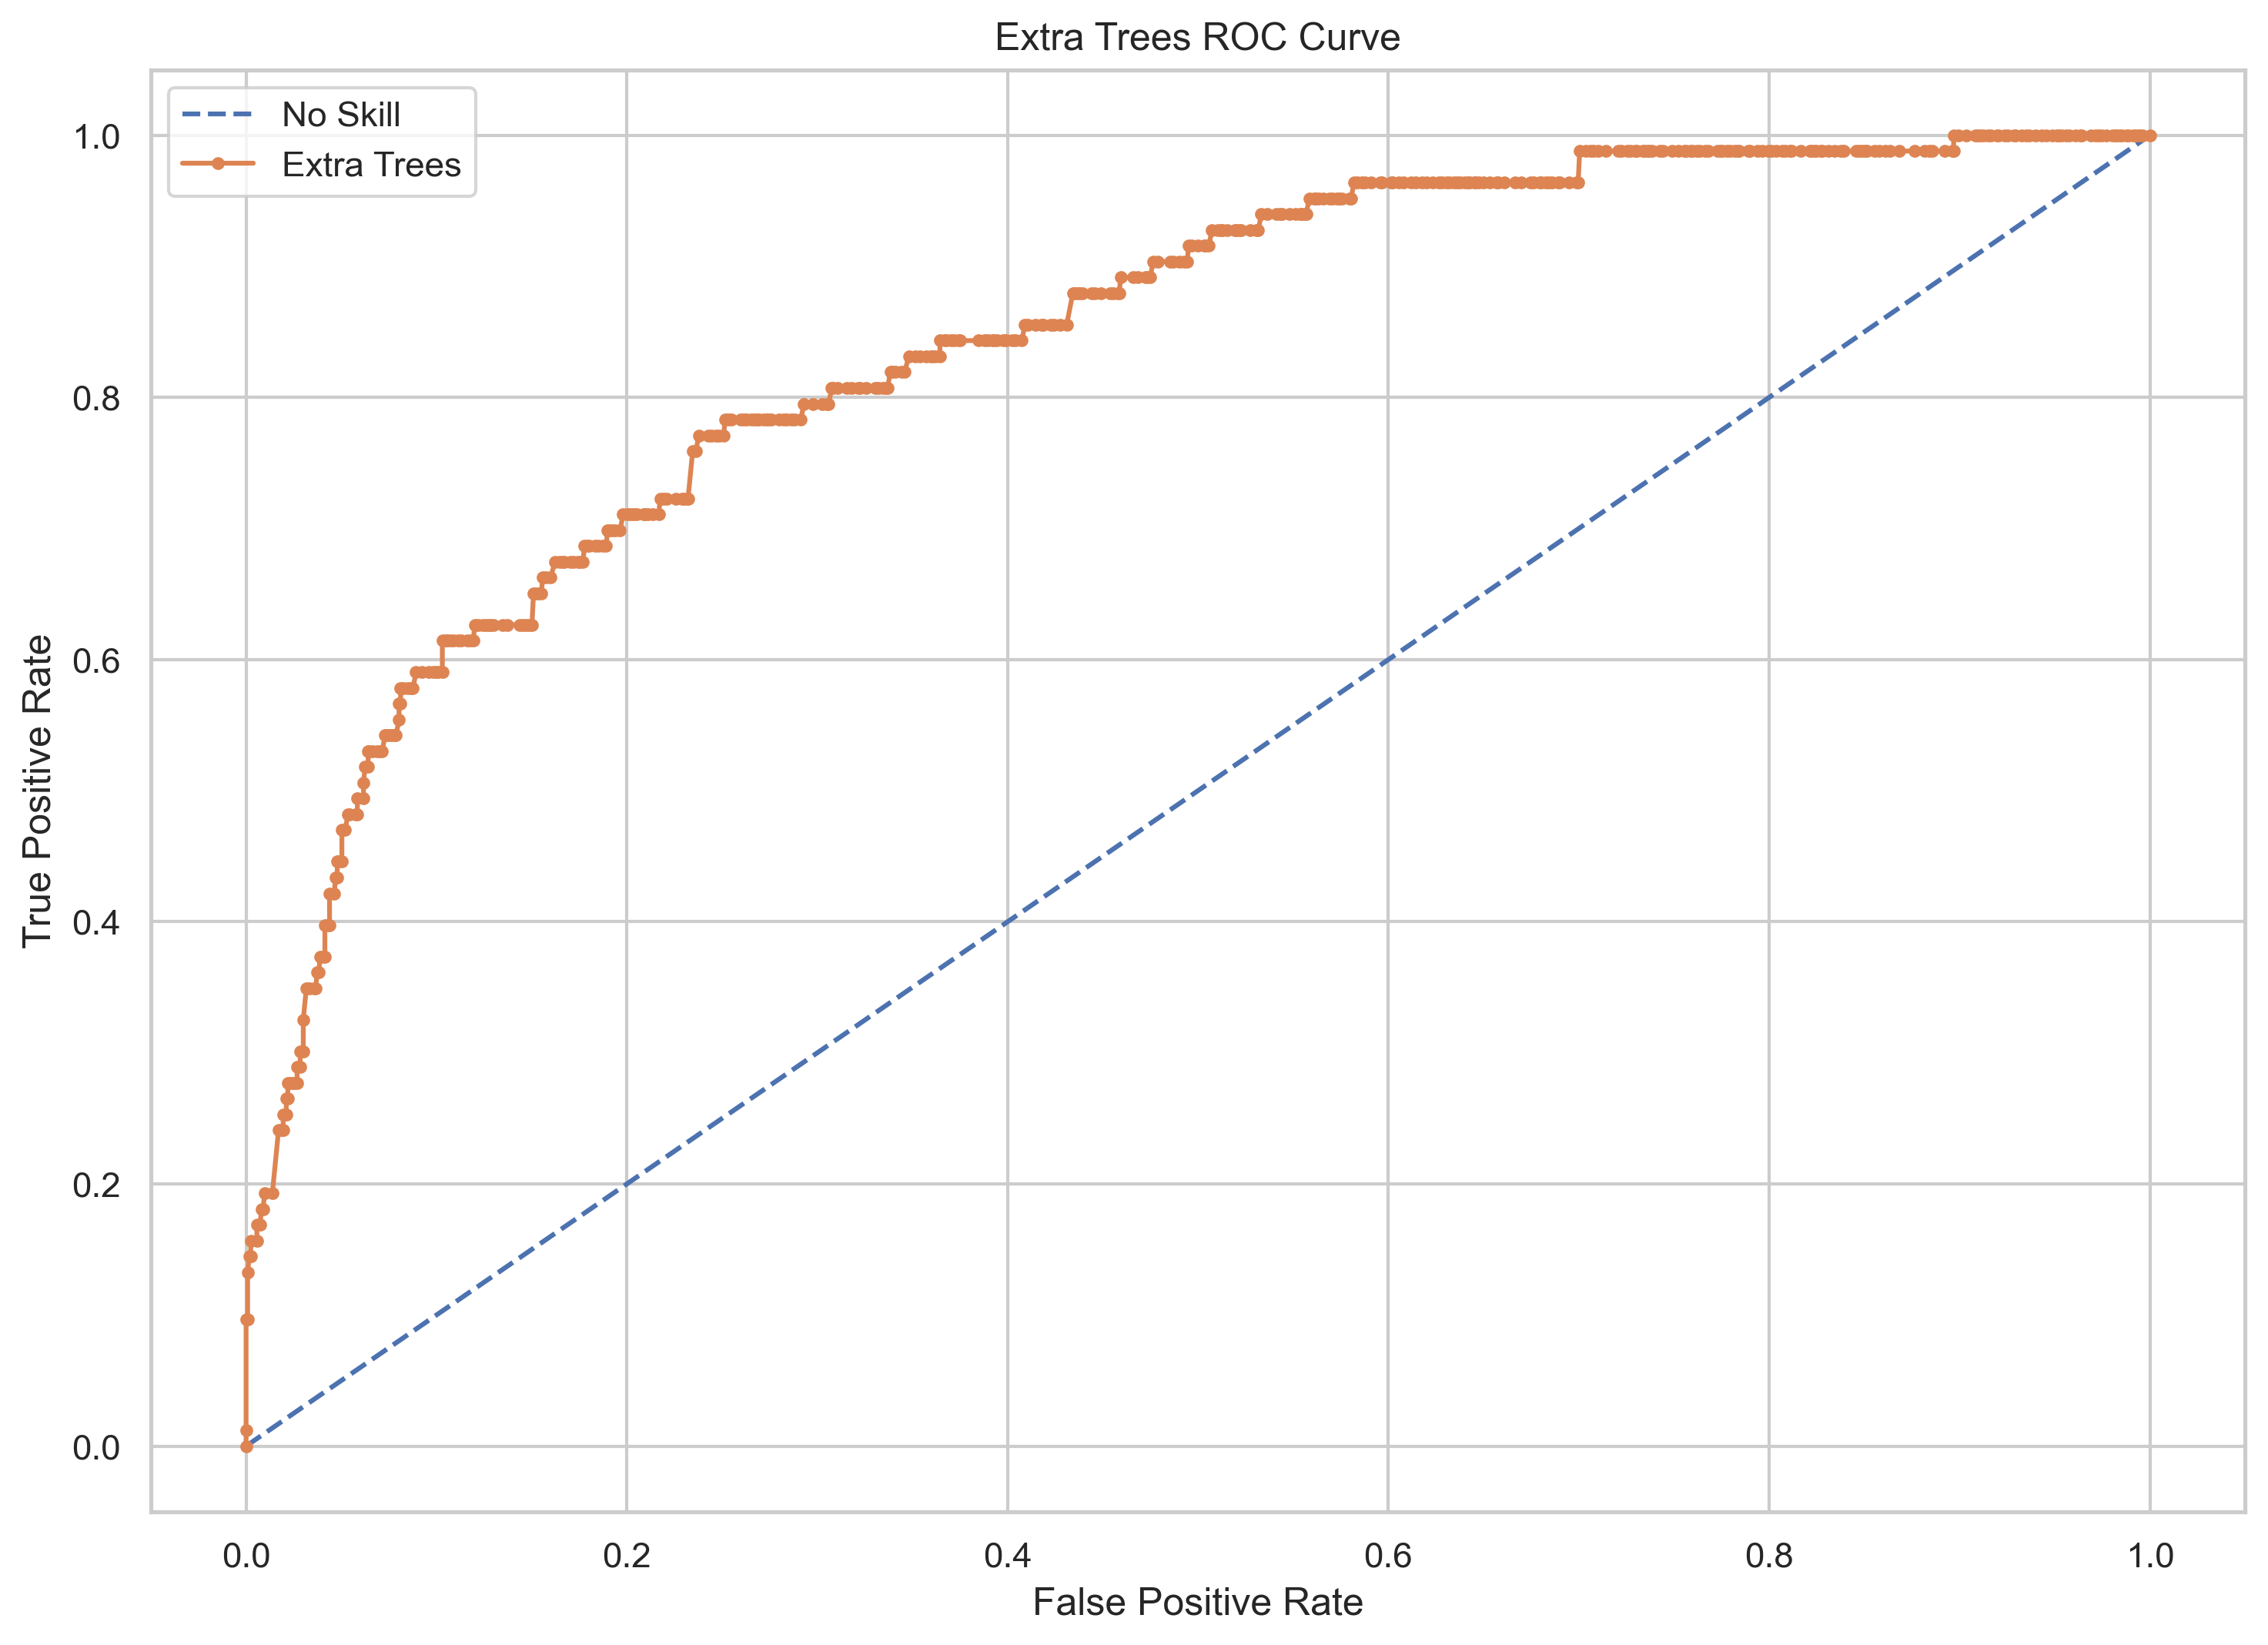


The Accuracy Score is 0.752851711026616 
The Precision Score is 0.17297297297297298 
The Recall Score is 0.7710843373493976 
The F Score is 0.282560706401766


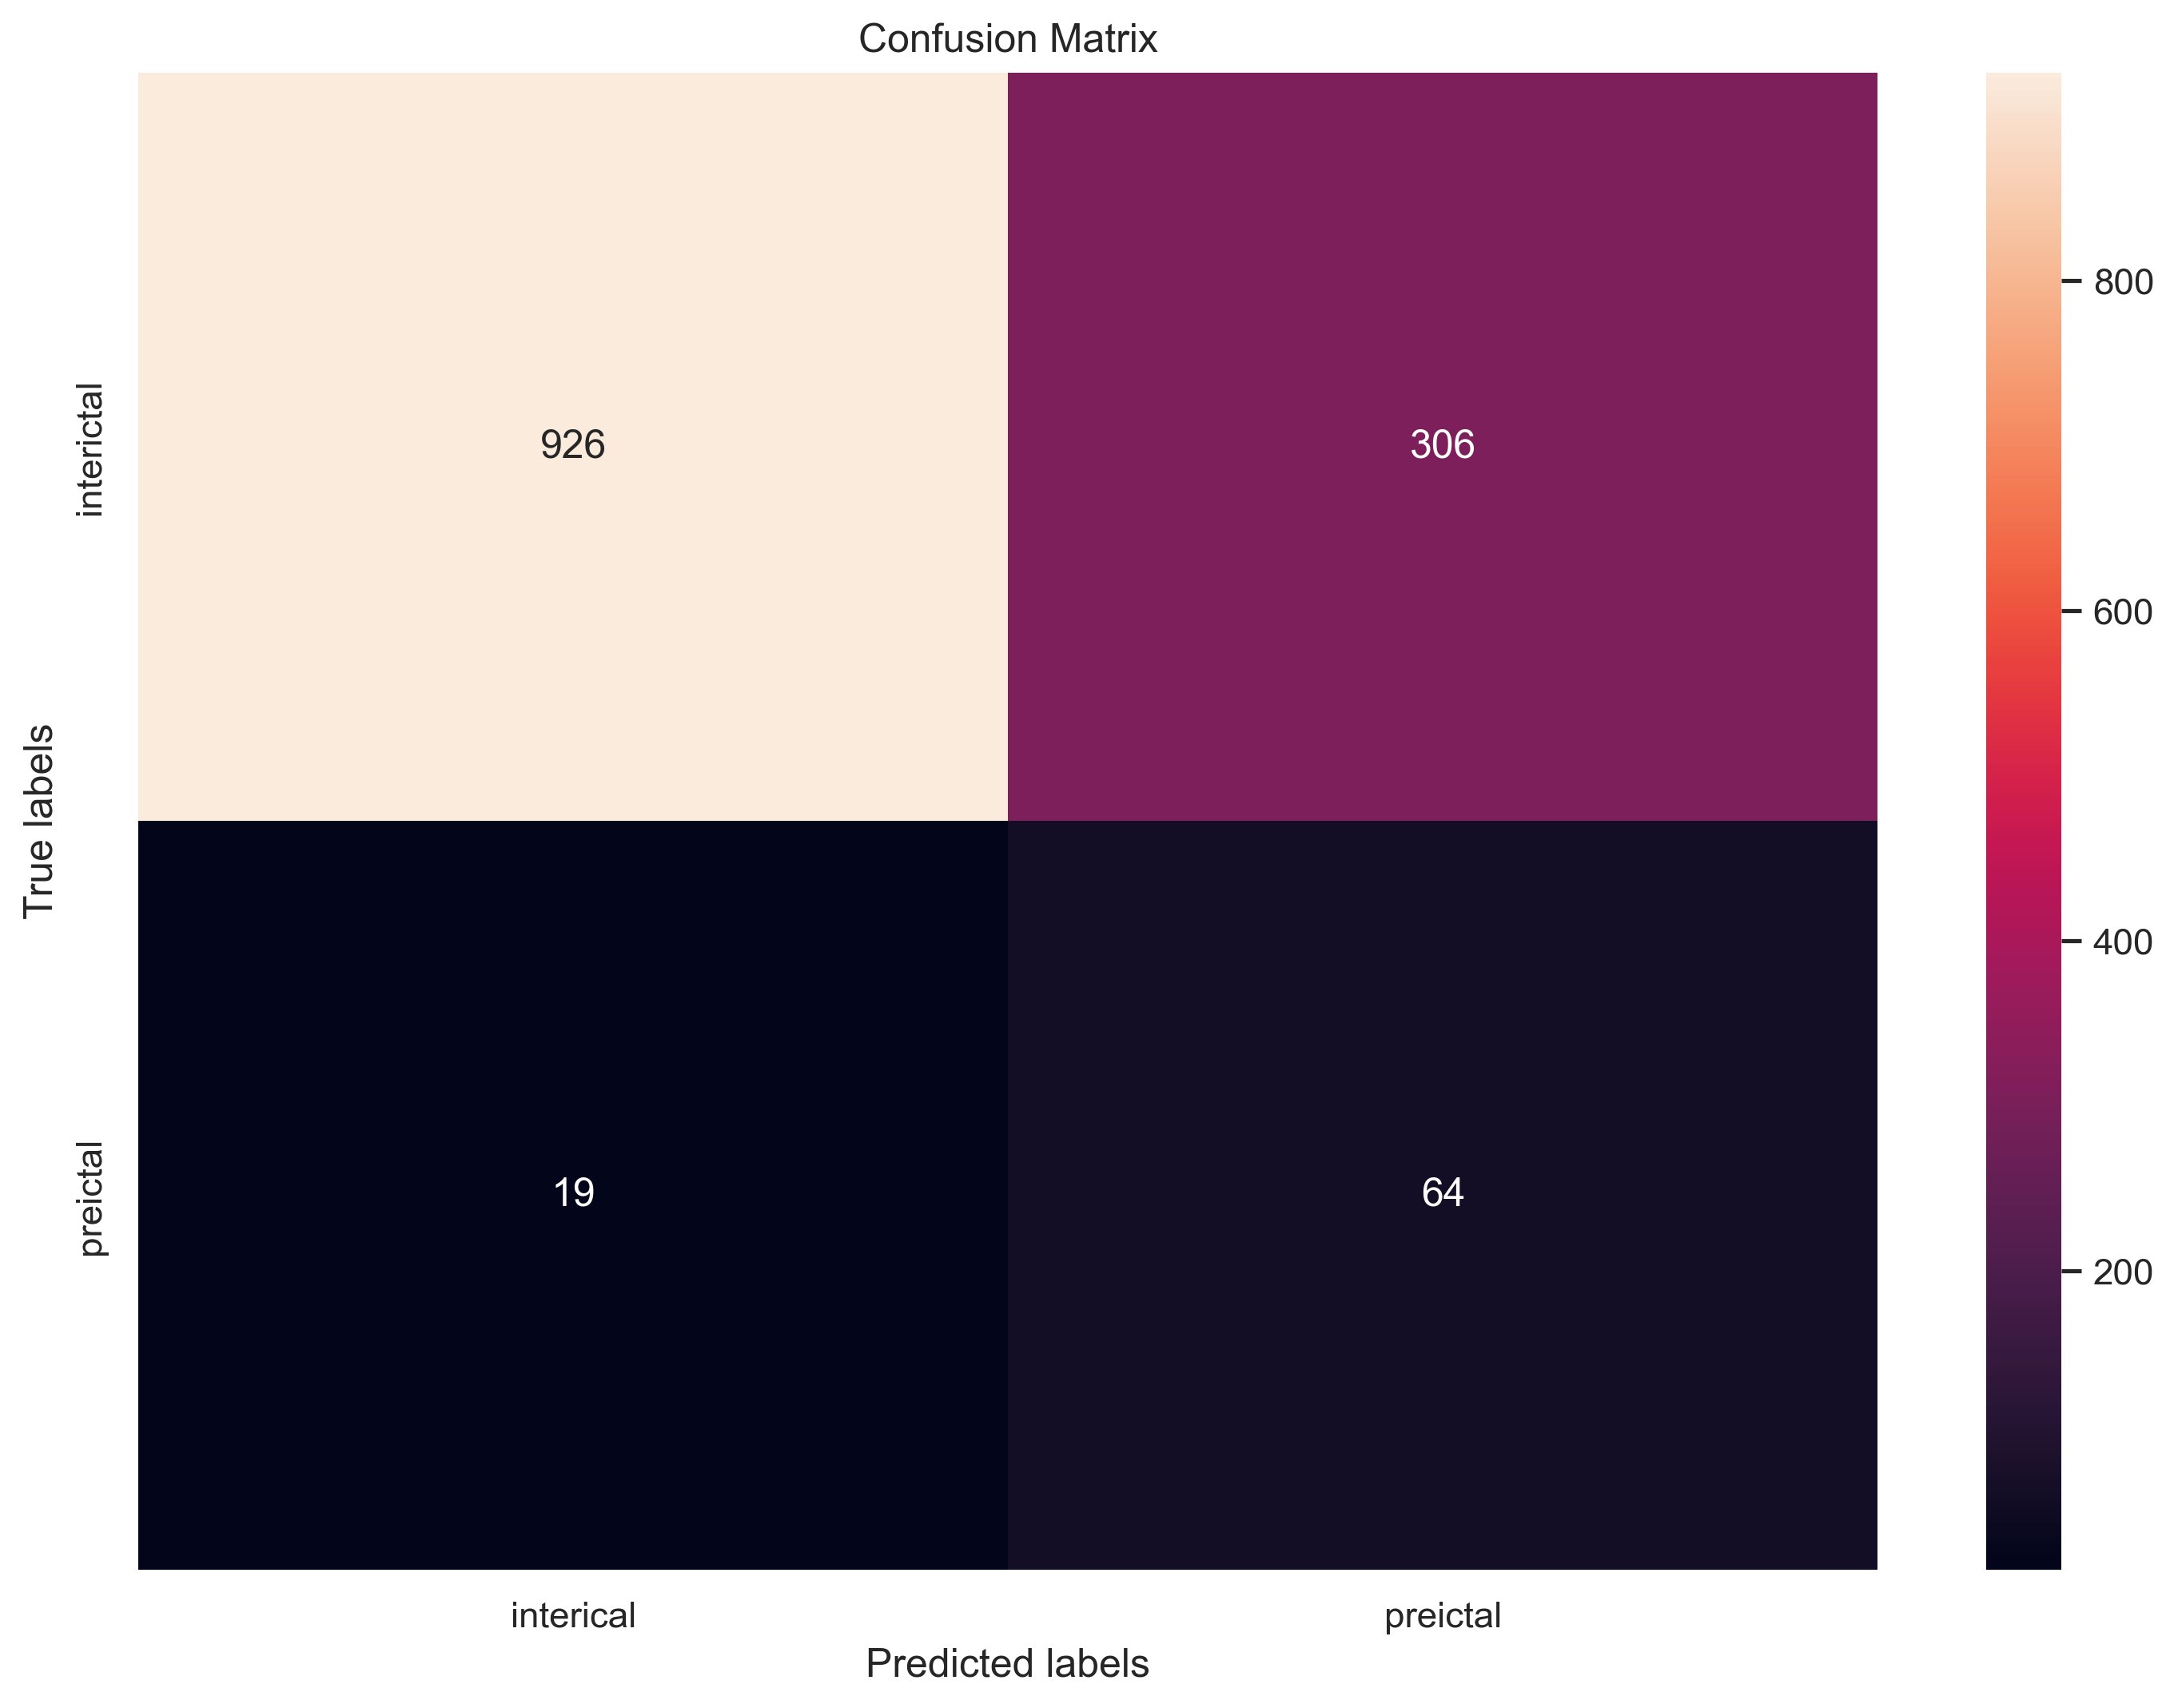

In [11]:
ExtraTrees = run_test(X_train, y_train,'Extra Trees')

original dataset shape: Counter({0.0: 2495, 1.0: 173})
Resample dataset shape Counter({0.0: 173, 1.0: 173})
No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.854


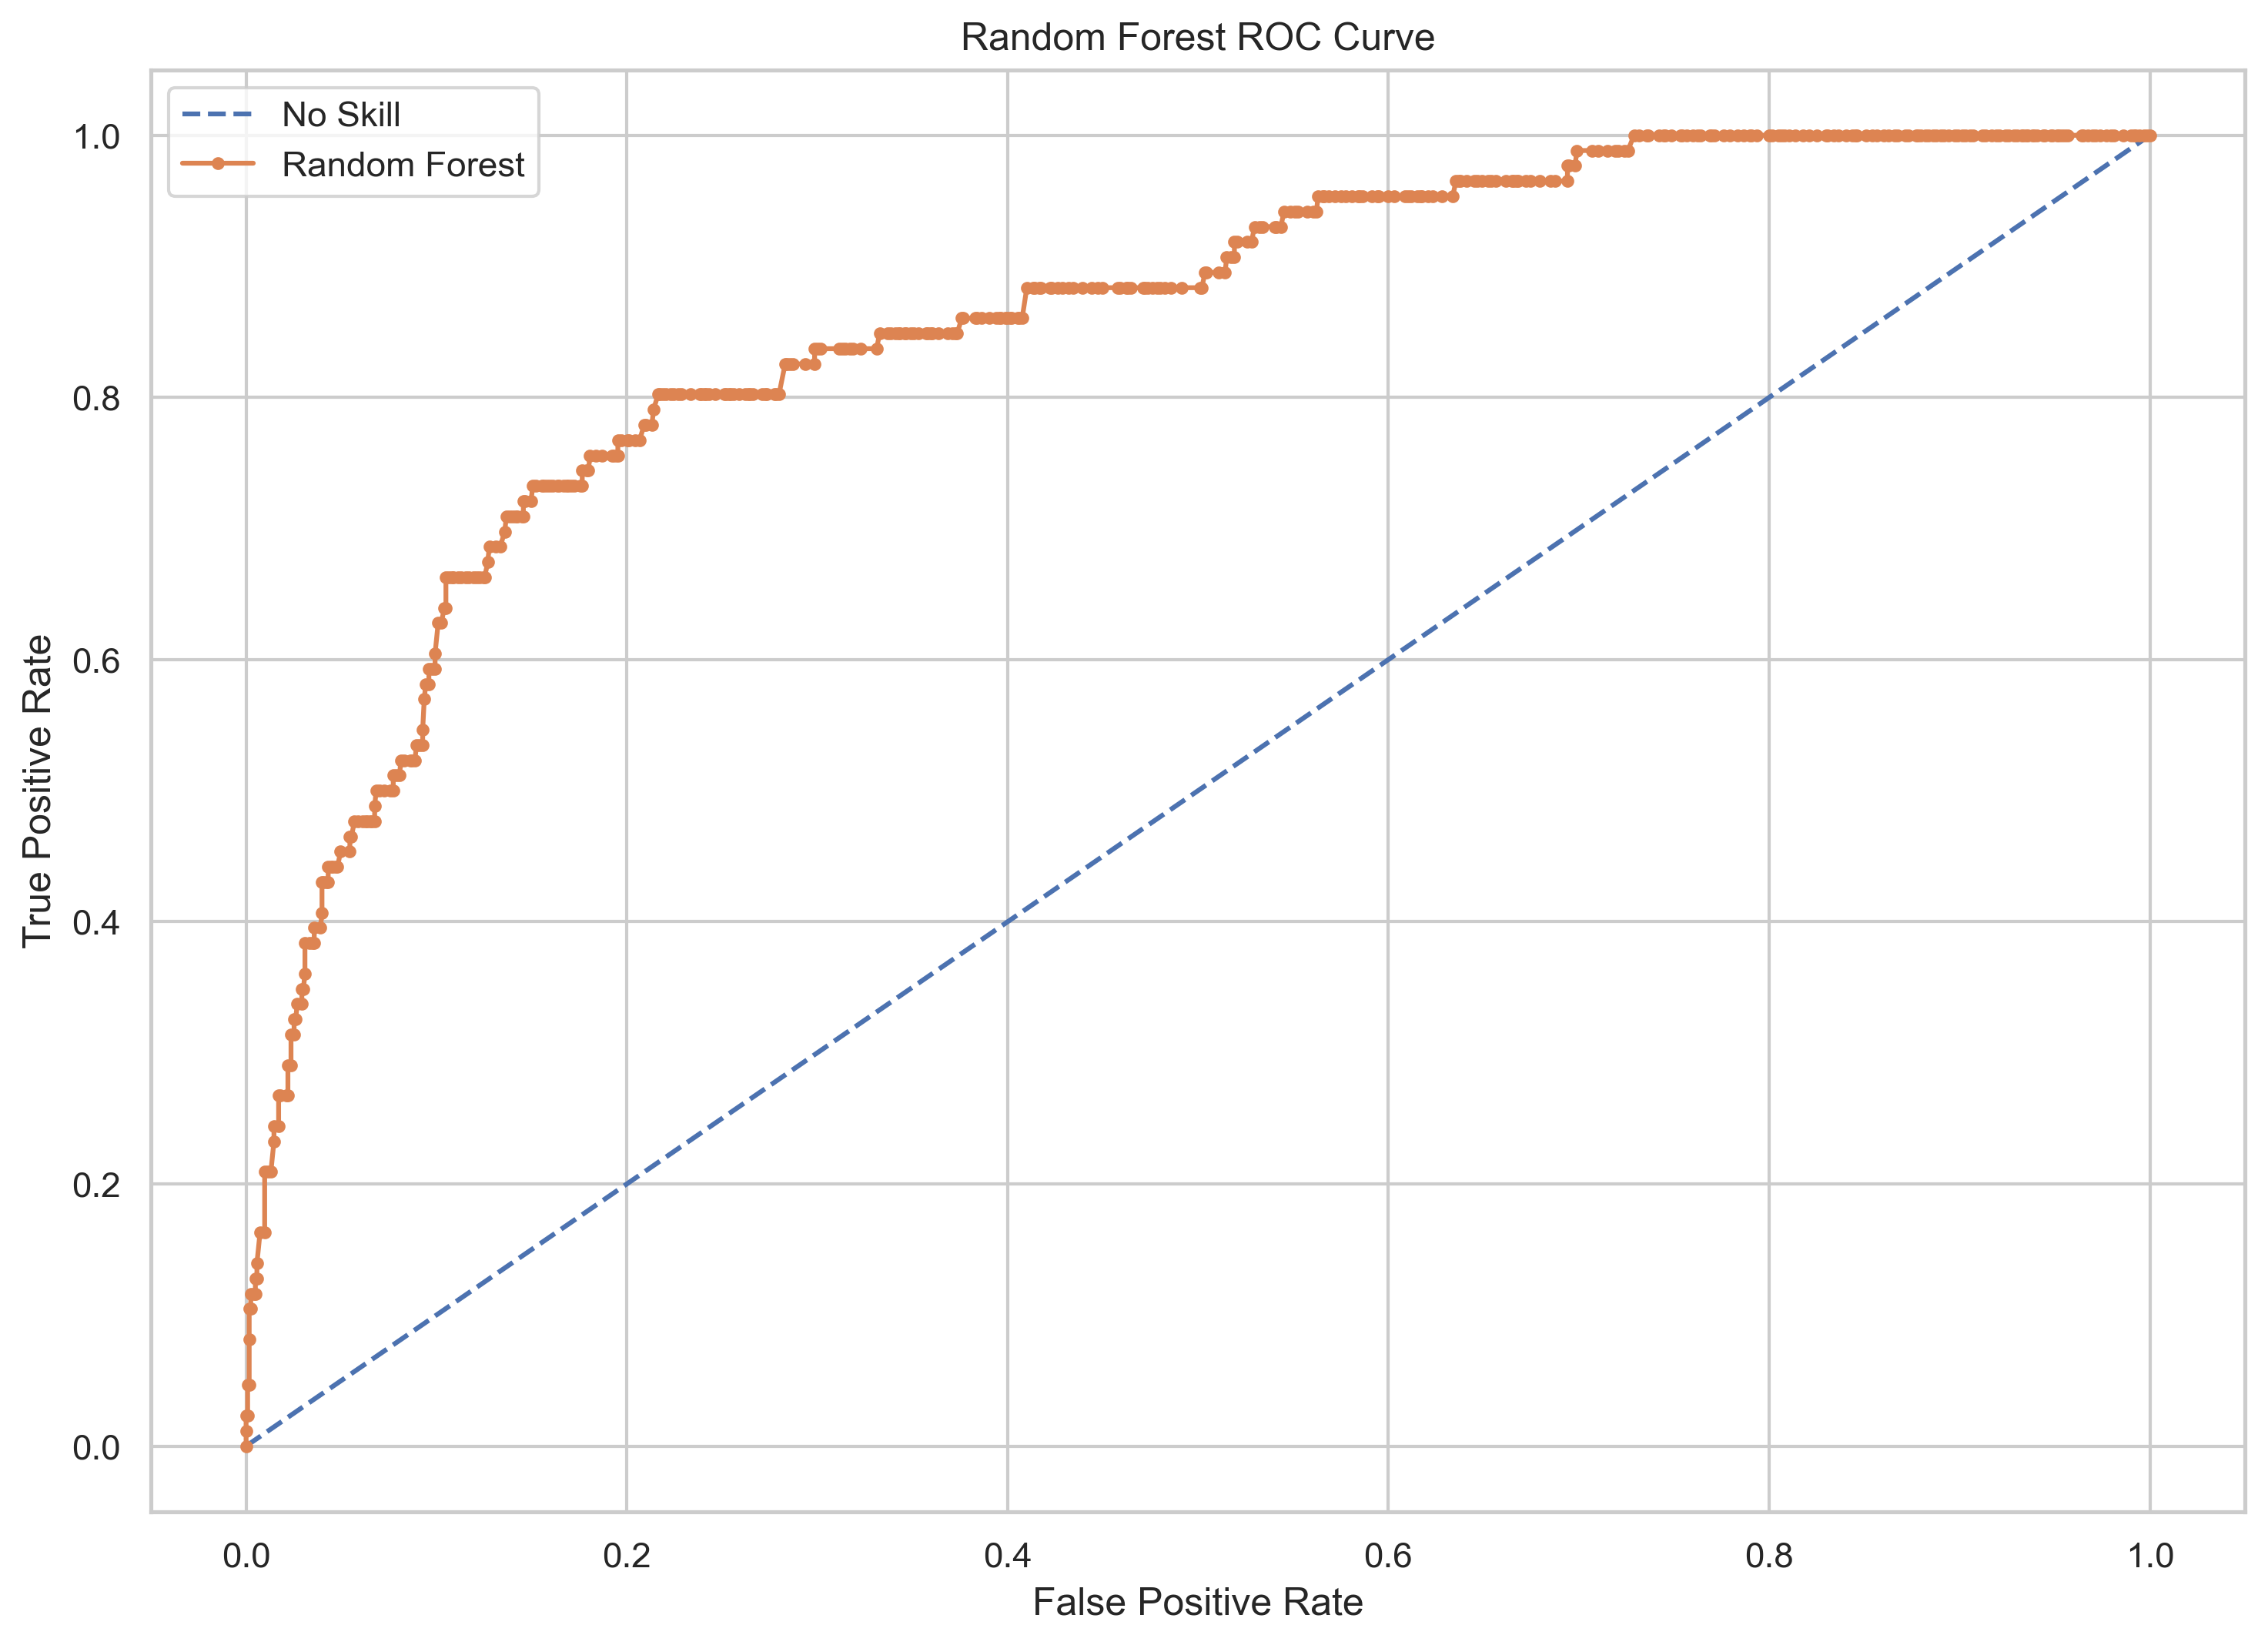


The Accuracy Score is 0.7688212927756654 
The Precision Score is 0.19382022471910113 
The Recall Score is 0.8023255813953488 
The F Score is 0.31221719457013575


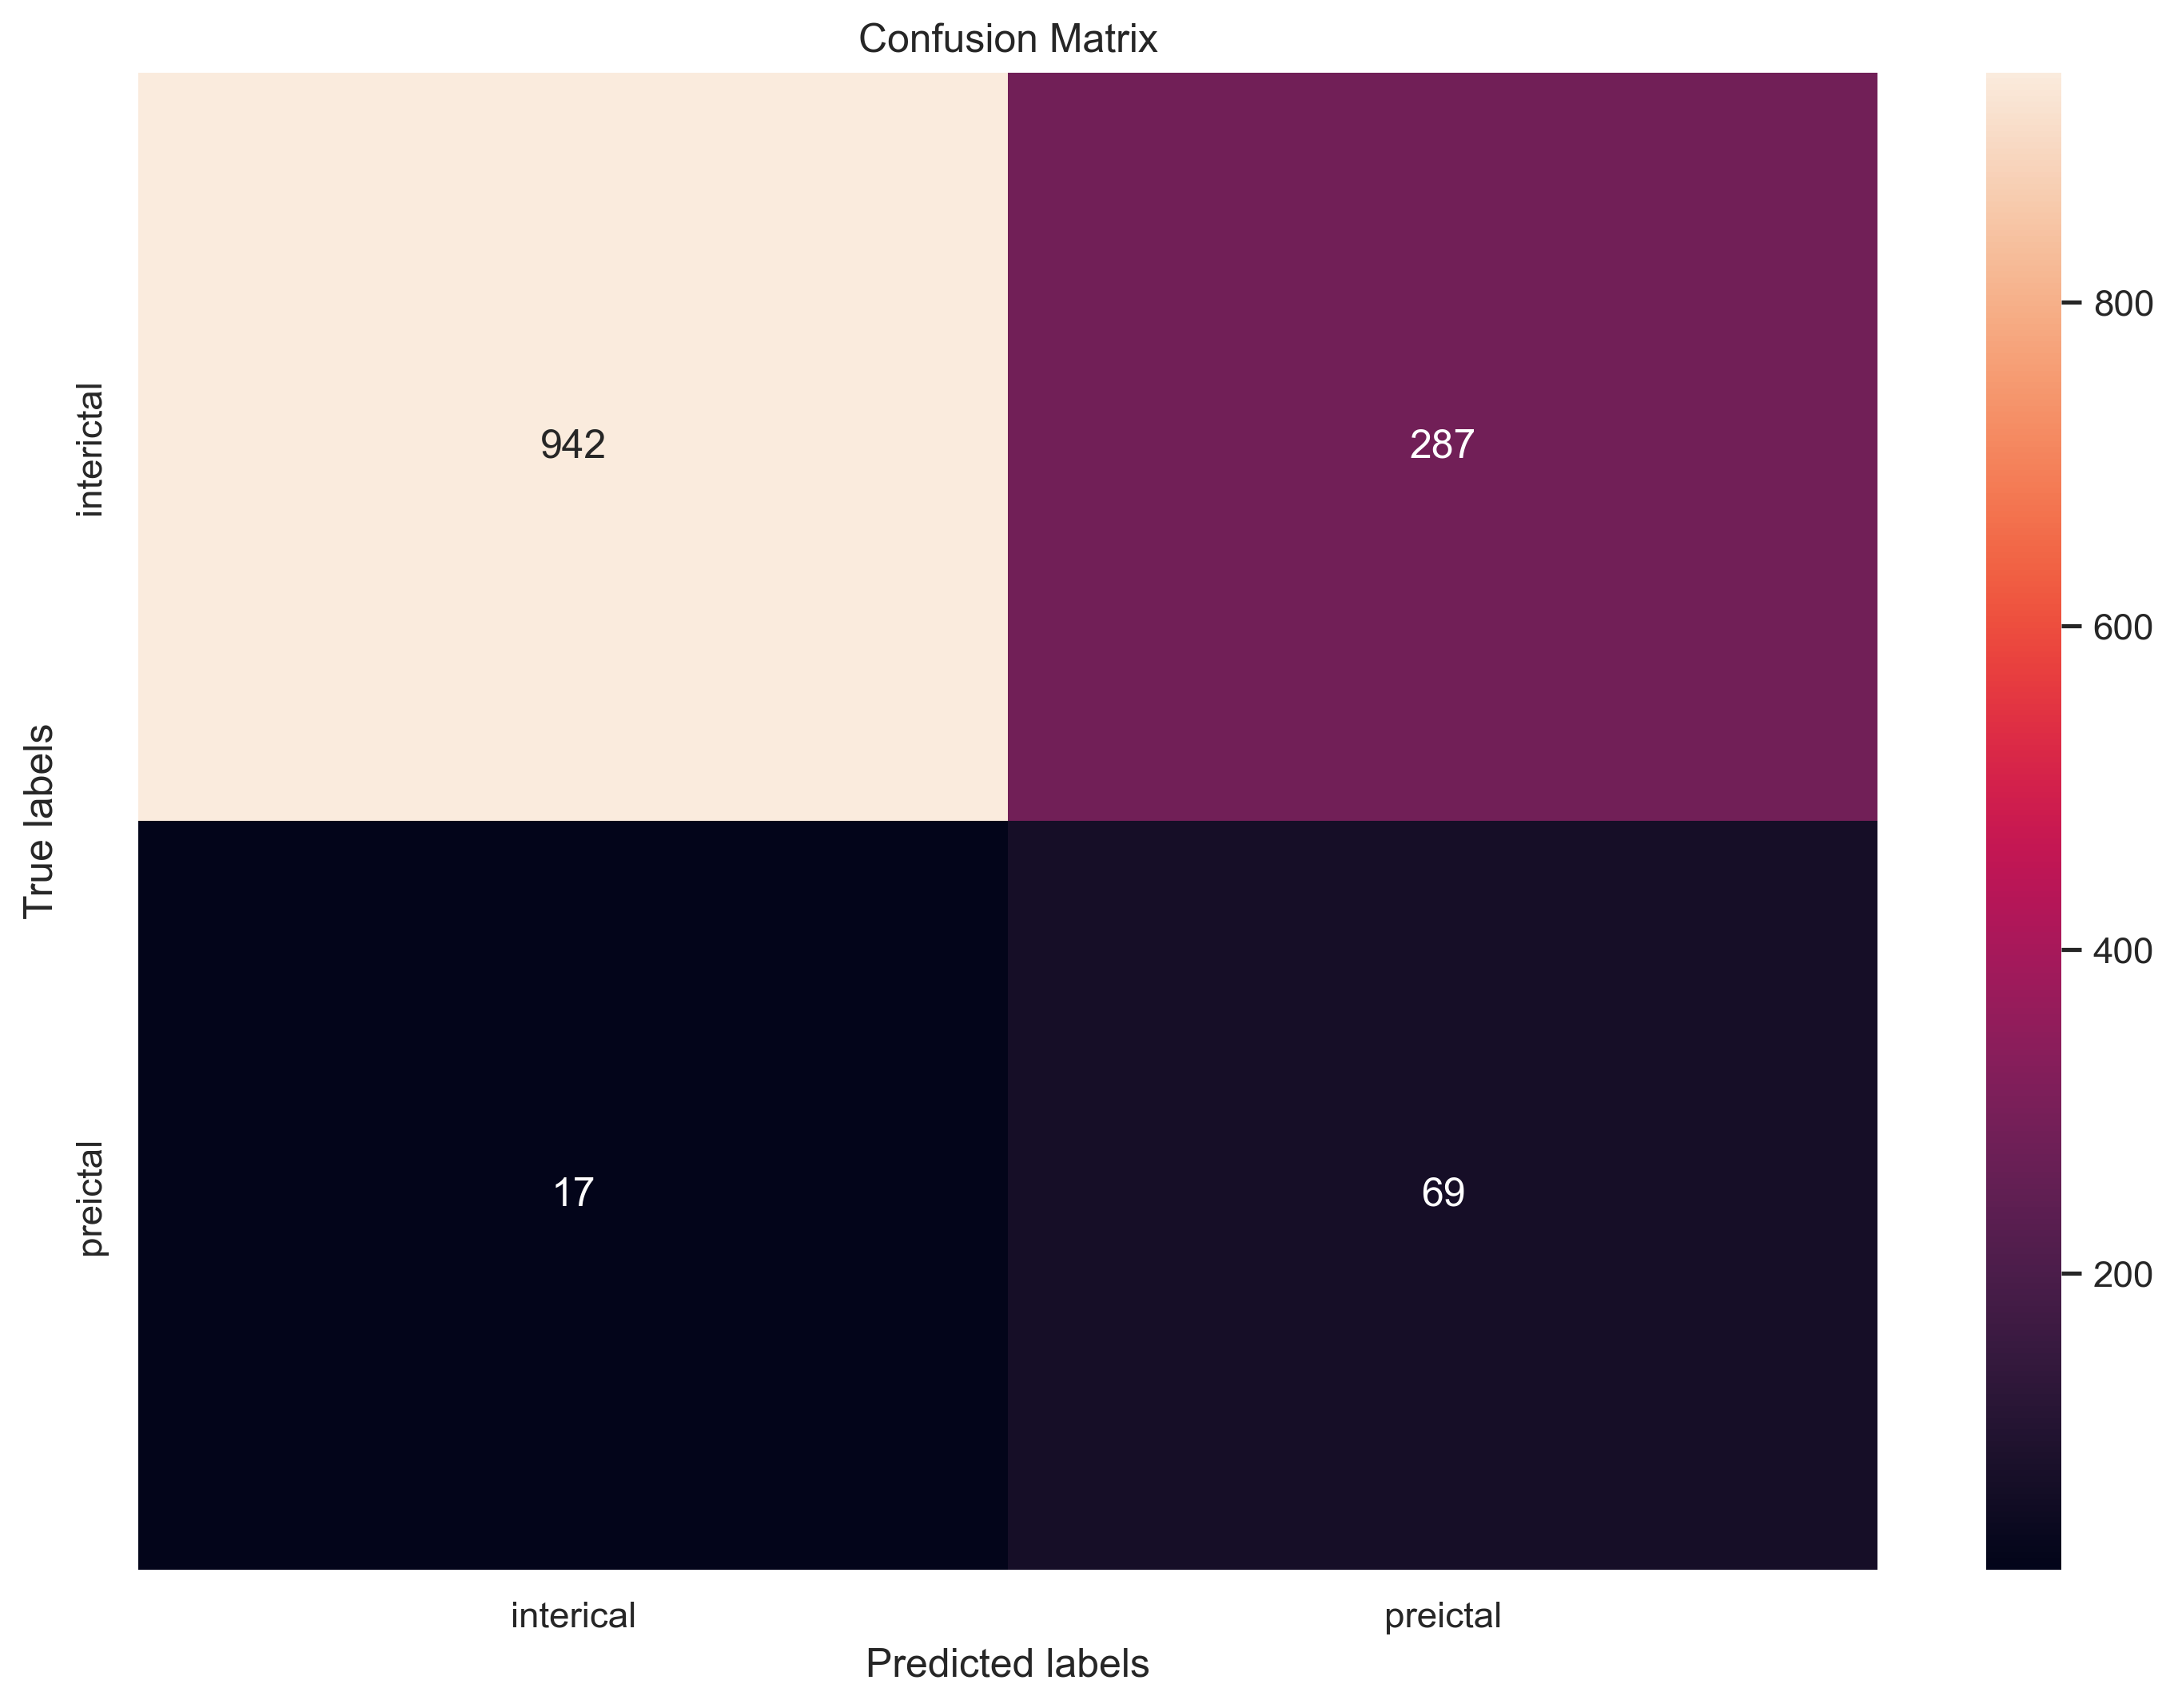

In [13]:
Random_Forest = run_test(X_train, y_train, 'Random Forest')

original dataset shape: Counter({0.0: 2497, 1.0: 171})
Resample dataset shape Counter({0.0: 171, 1.0: 171})
No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.627


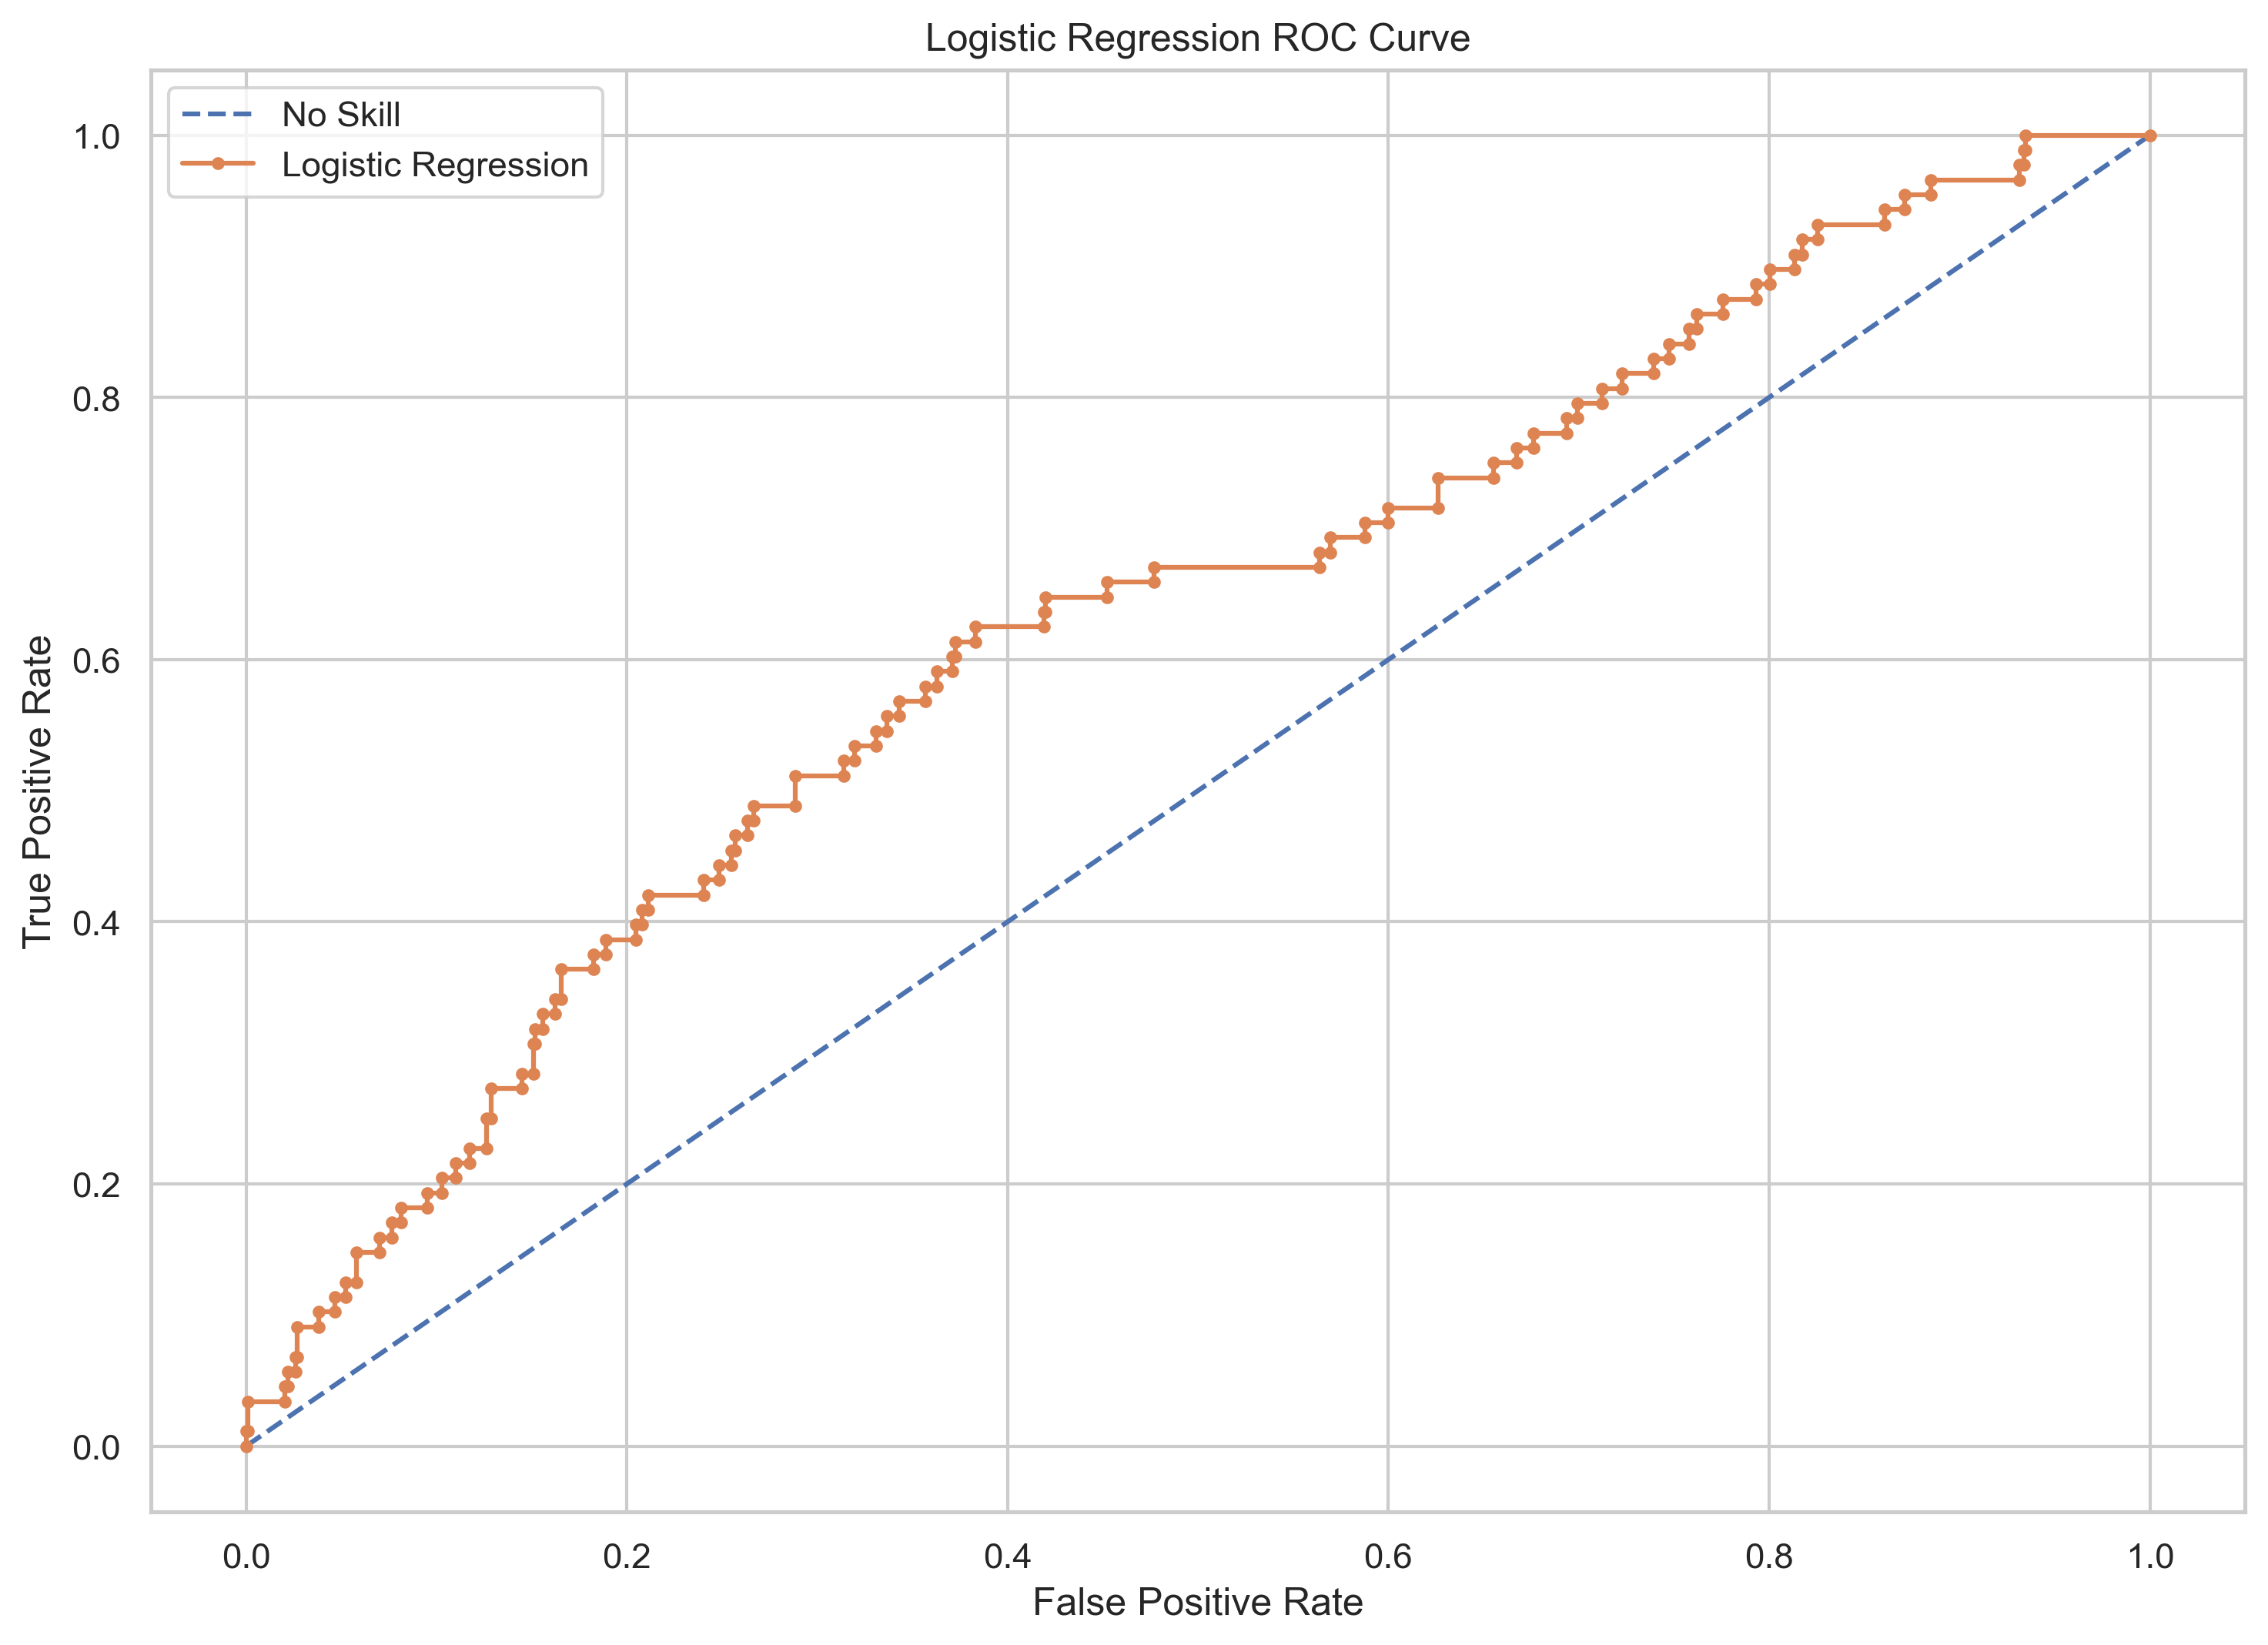


The Accuracy Score is 0.5574144486692015 
The Precision Score is 0.09375 
The Recall Score is 0.6477272727272727 
The F Score is 0.16379310344827586


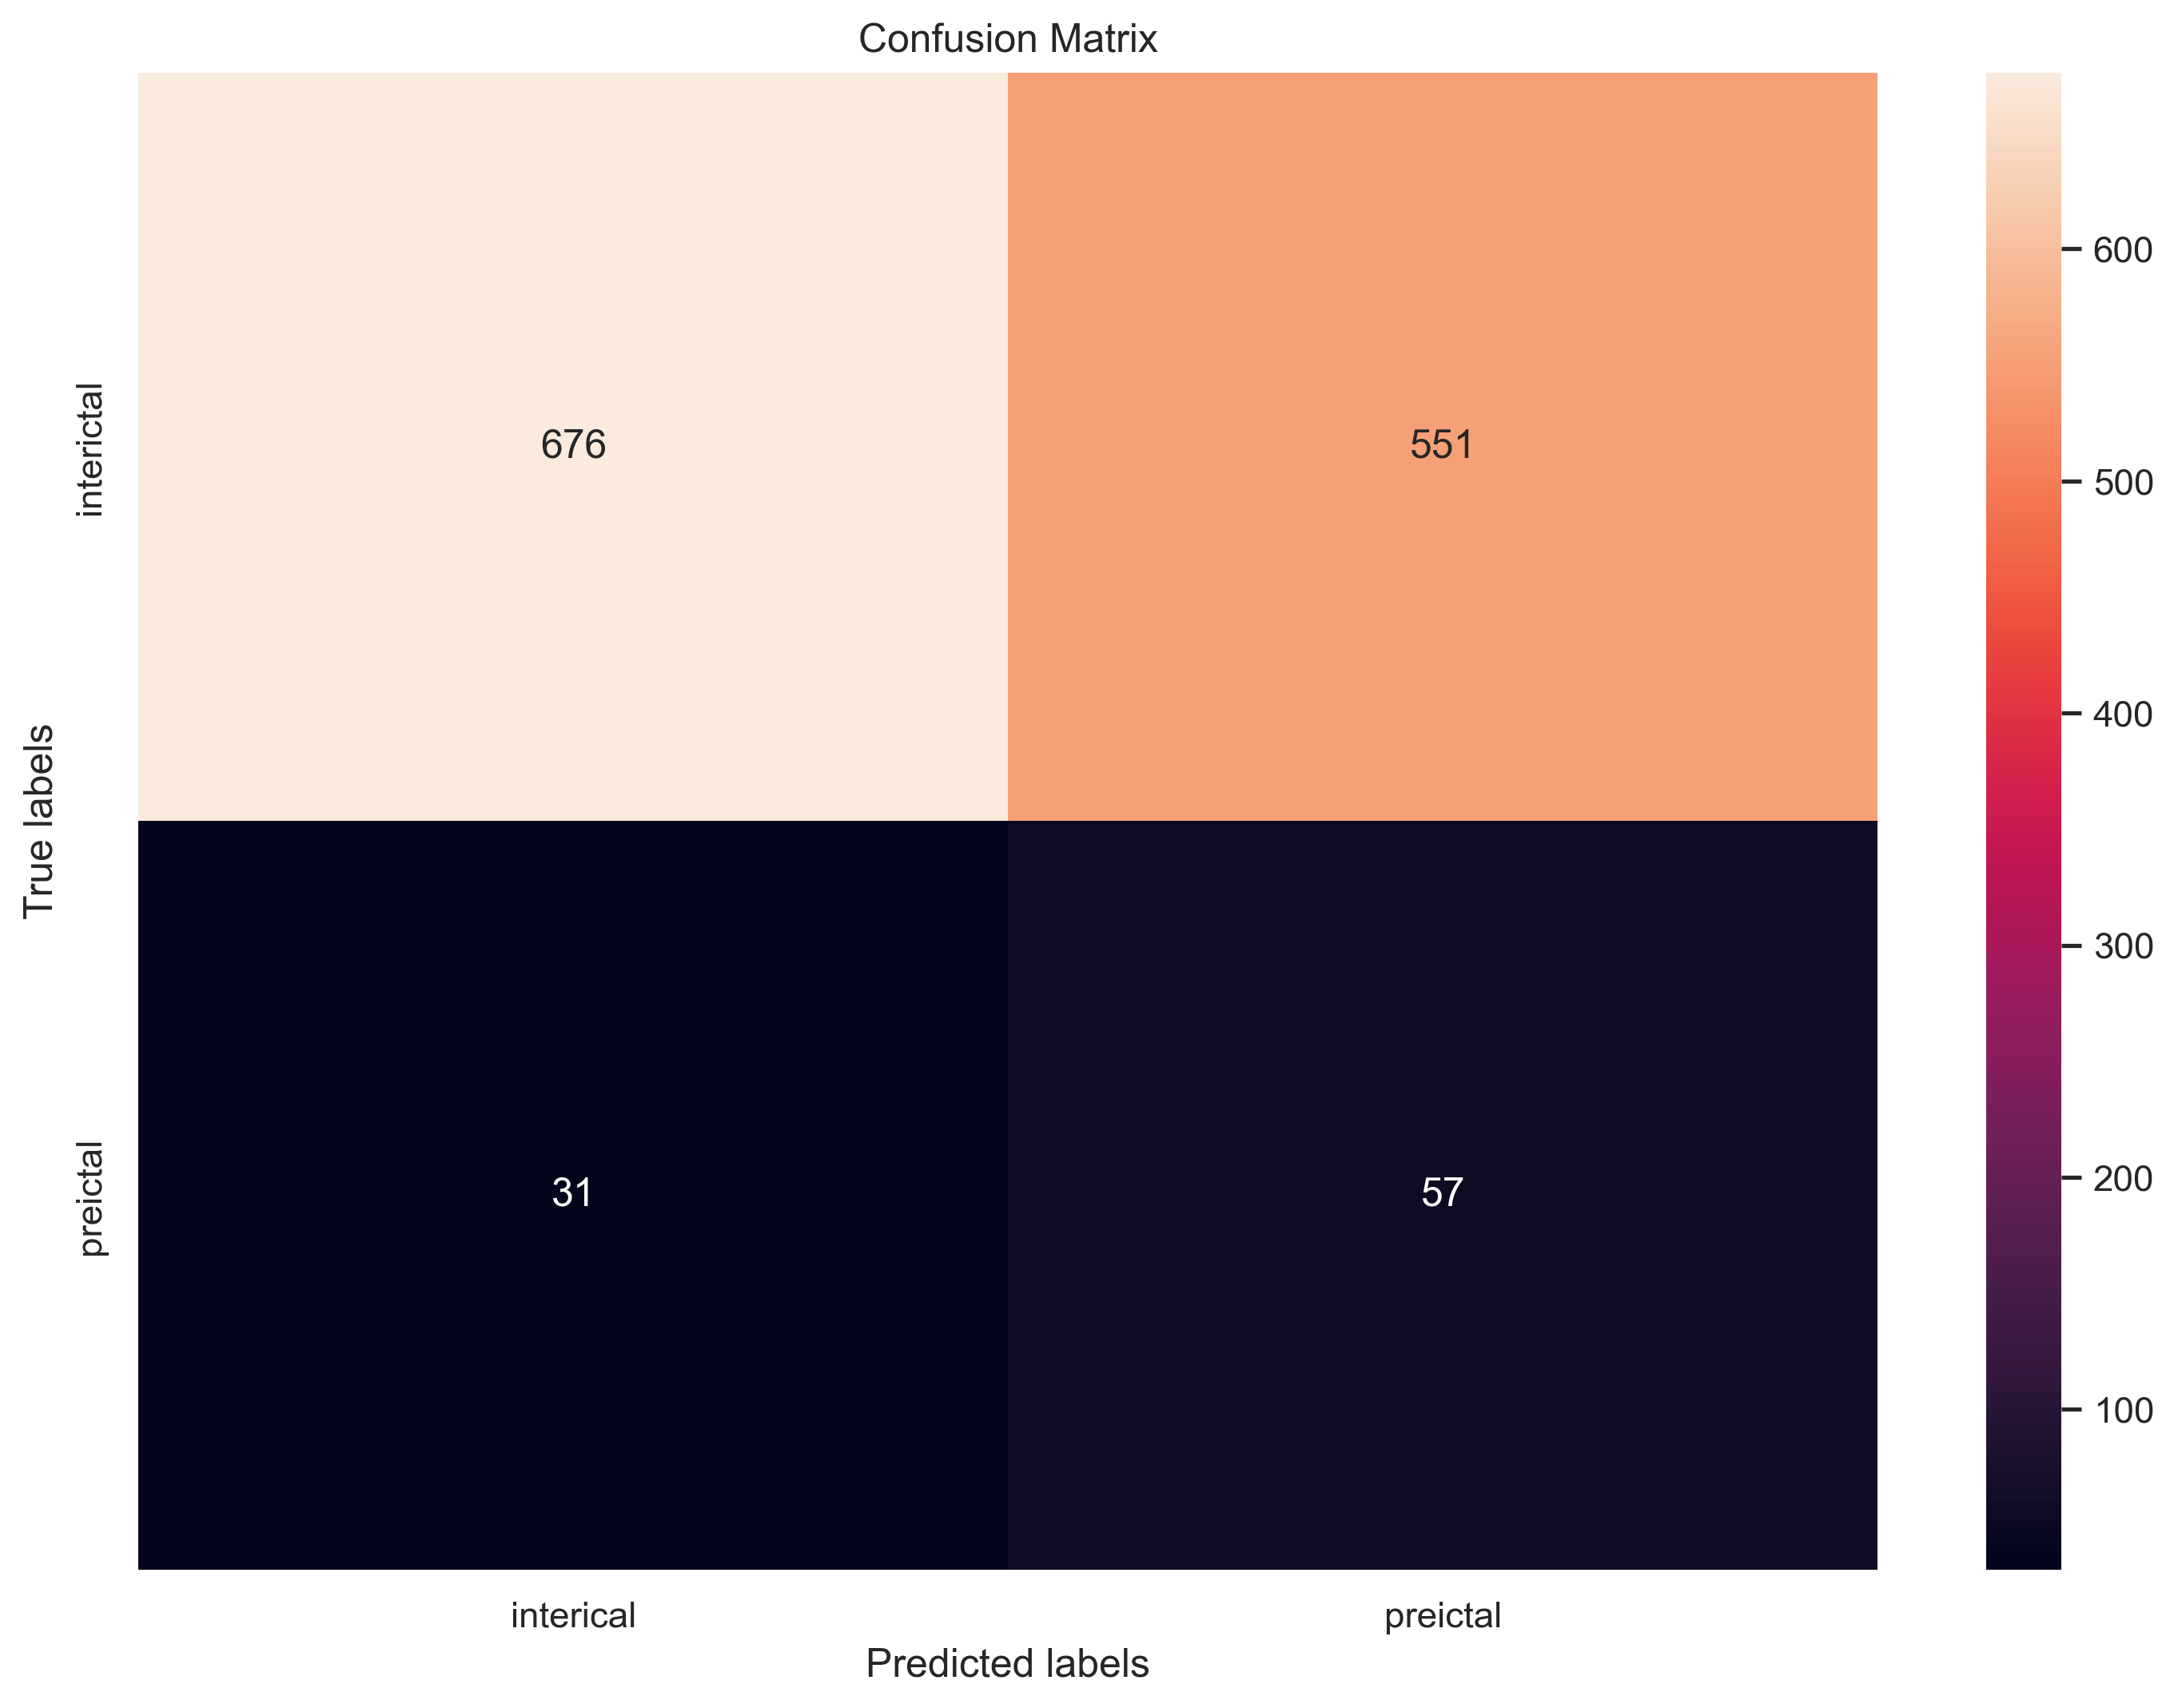

In [14]:
Logistic_Regression = run_test(X_train, y_train, 'Logistic Regression')

original dataset shape: Counter({0.0: 2502, 1.0: 166})
Resample dataset shape Counter({0.0: 166, 1.0: 166})
No Skill: ROC AUC=0.500
Bayes: ROC AUC=0.565


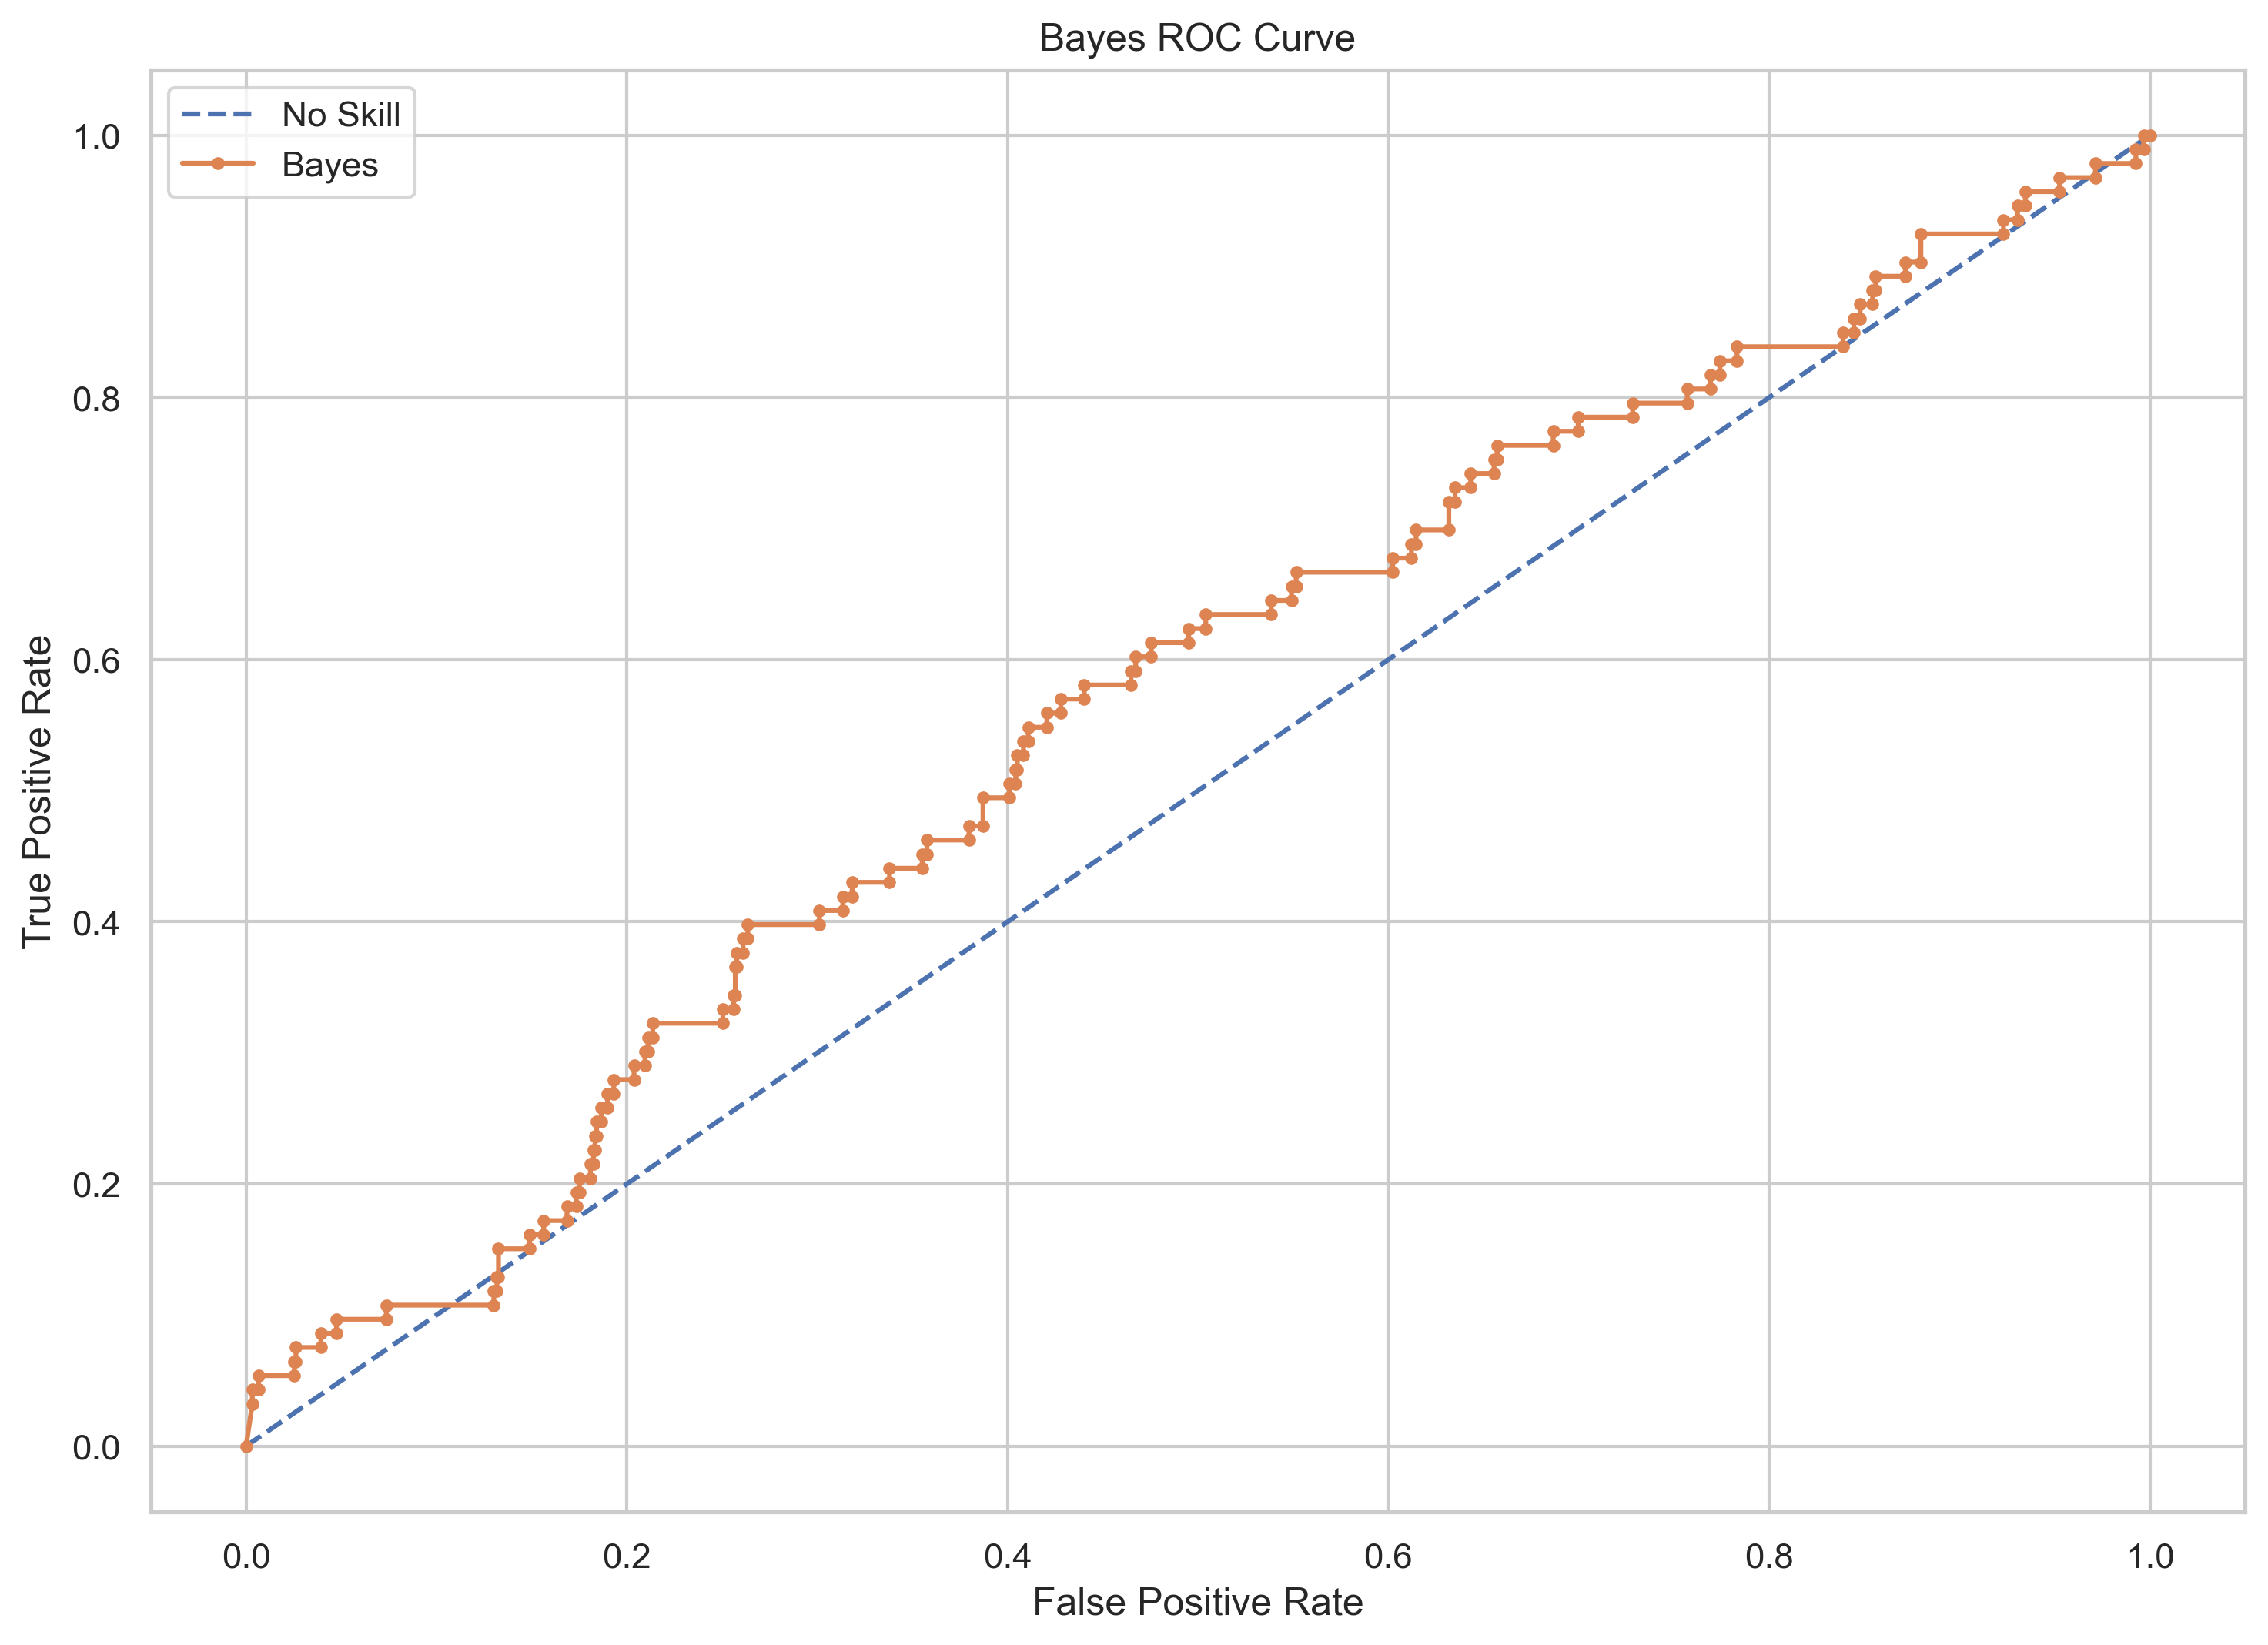


The Accuracy Score is 0.9262357414448669 
The Precision Score is 0.3333333333333333 
The Recall Score is 0.043010752688172046 
The F Score is 0.0761904761904762


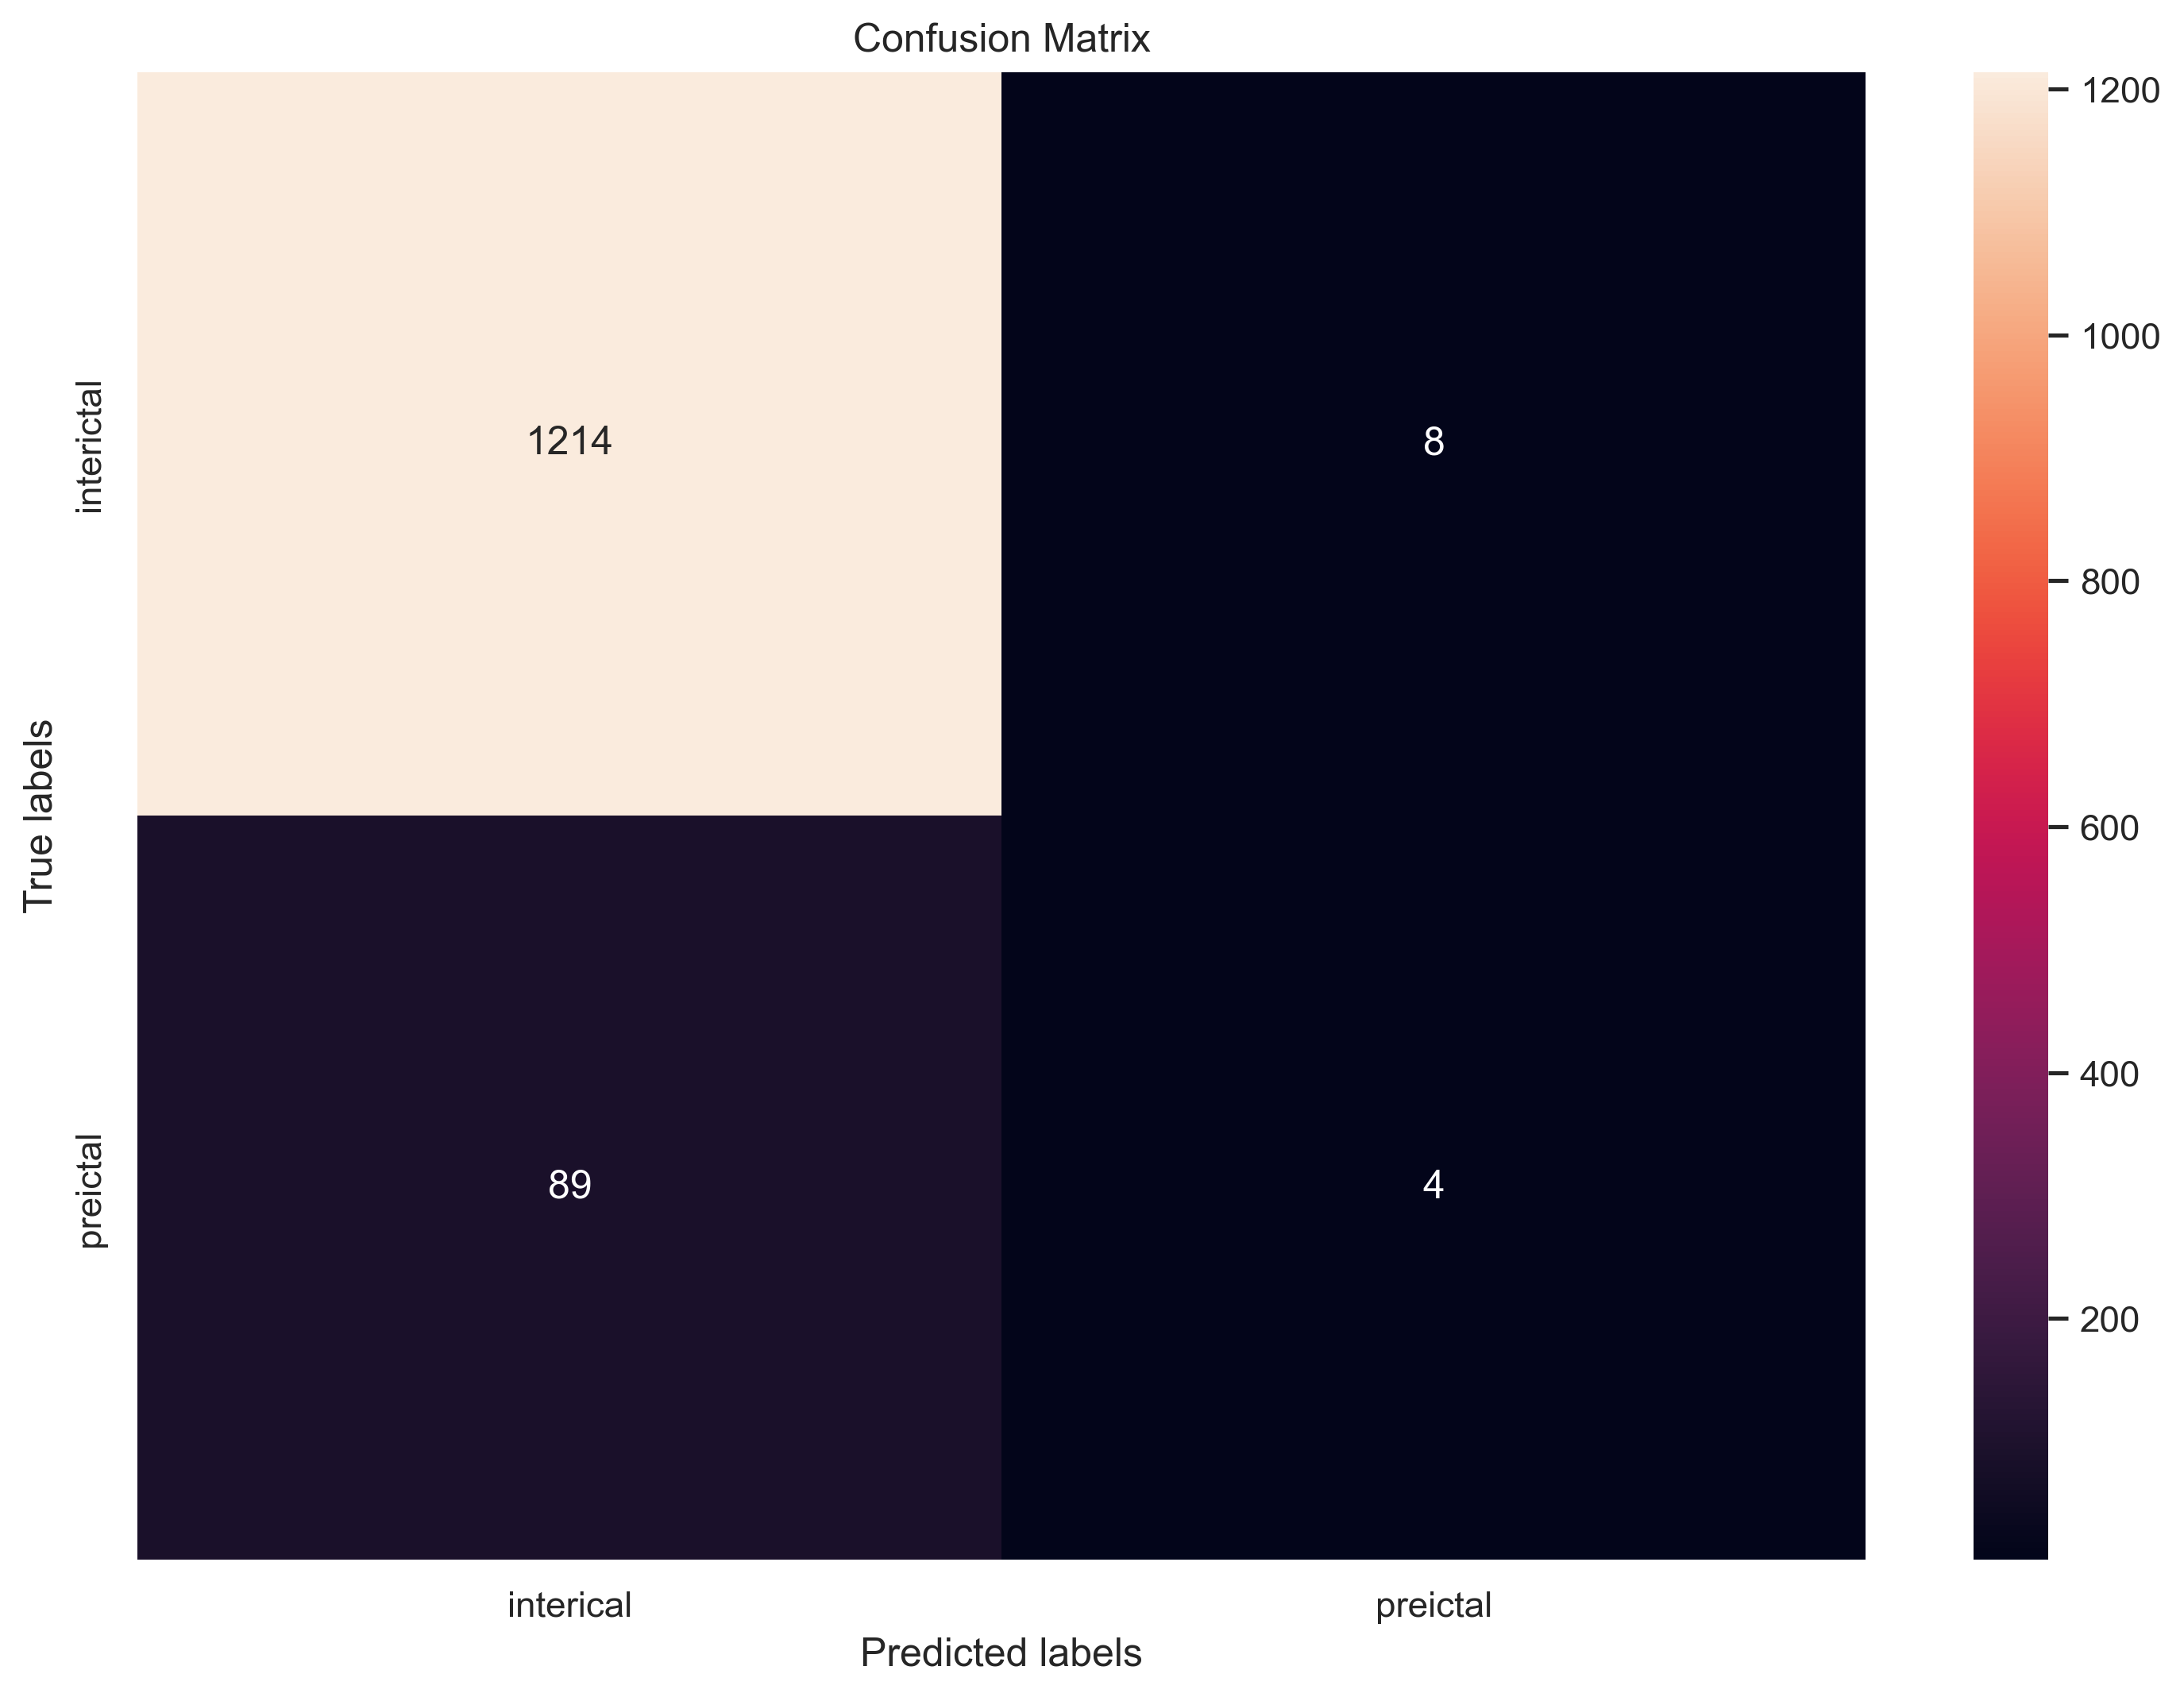

In [15]:
Bayes = run_test(X_train, y_train,  'Bayes')

original dataset shape: Counter({0.0: 2493, 1.0: 175})
Resample dataset shape Counter({0.0: 175, 1.0: 175})
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.859


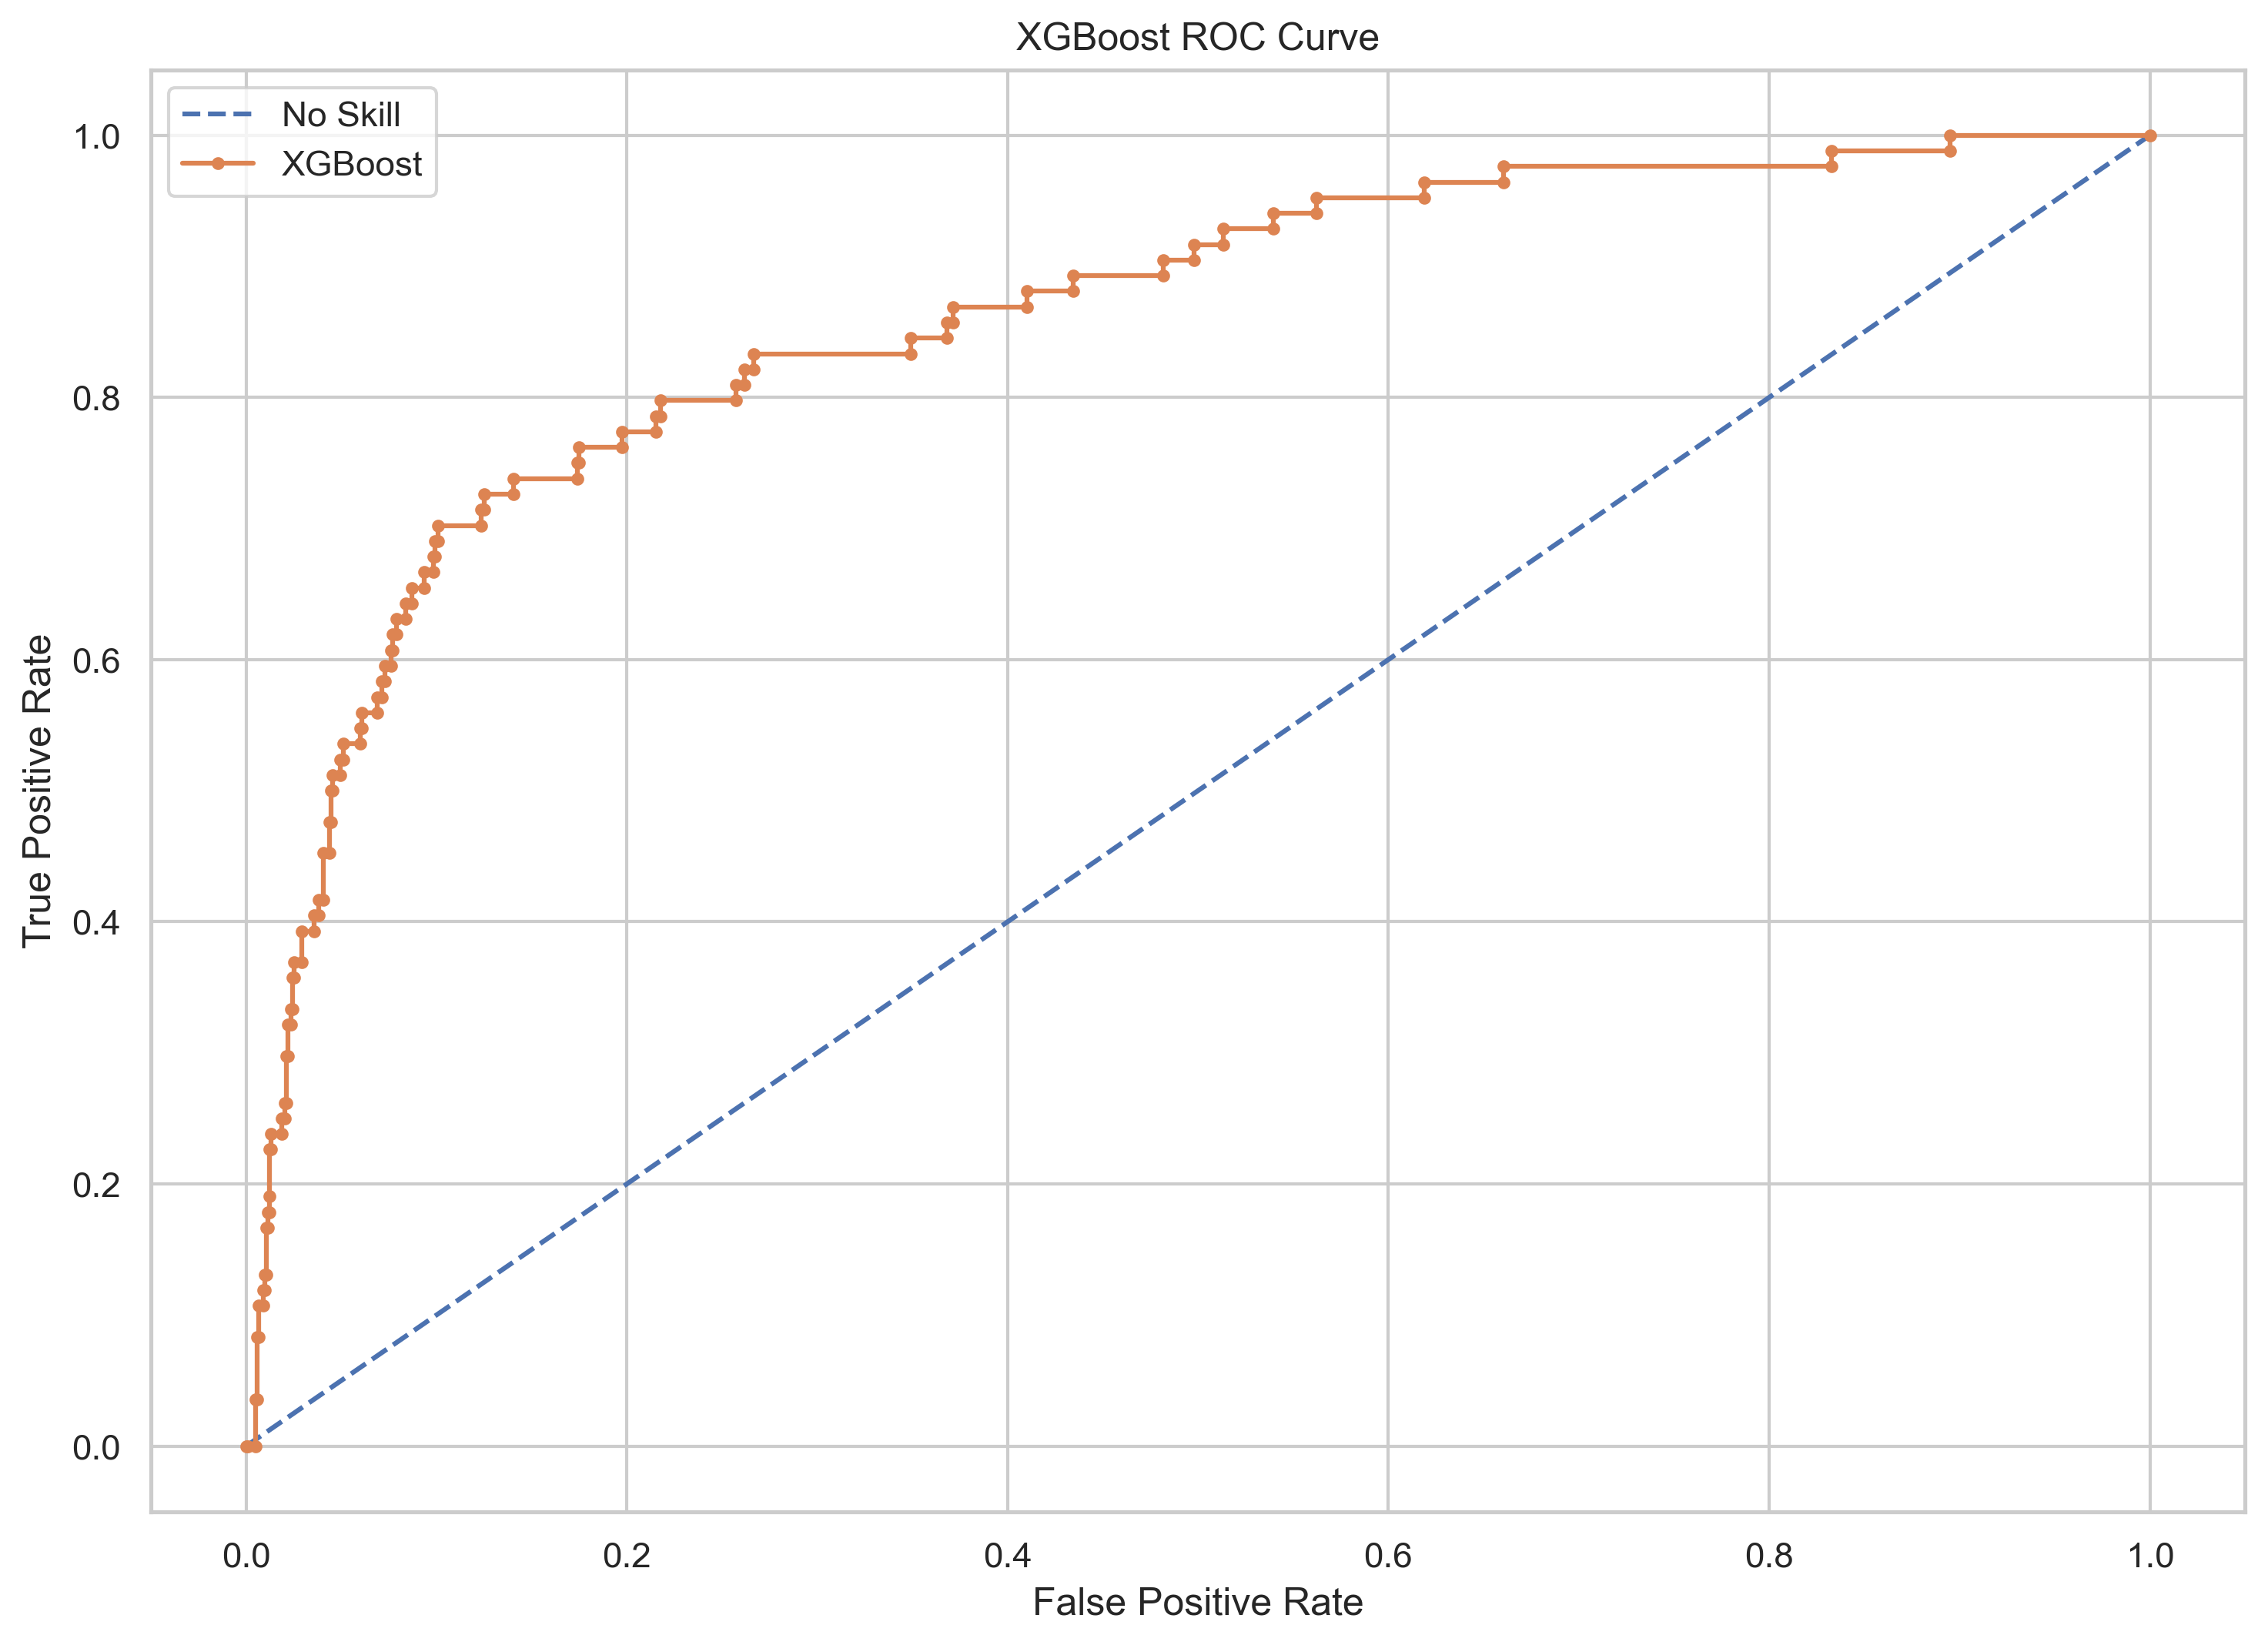


The Accuracy Score is 0.7779467680608365 
The Precision Score is 0.195906432748538 
The Recall Score is 0.7976190476190477 
The F Score is 0.3145539906103286


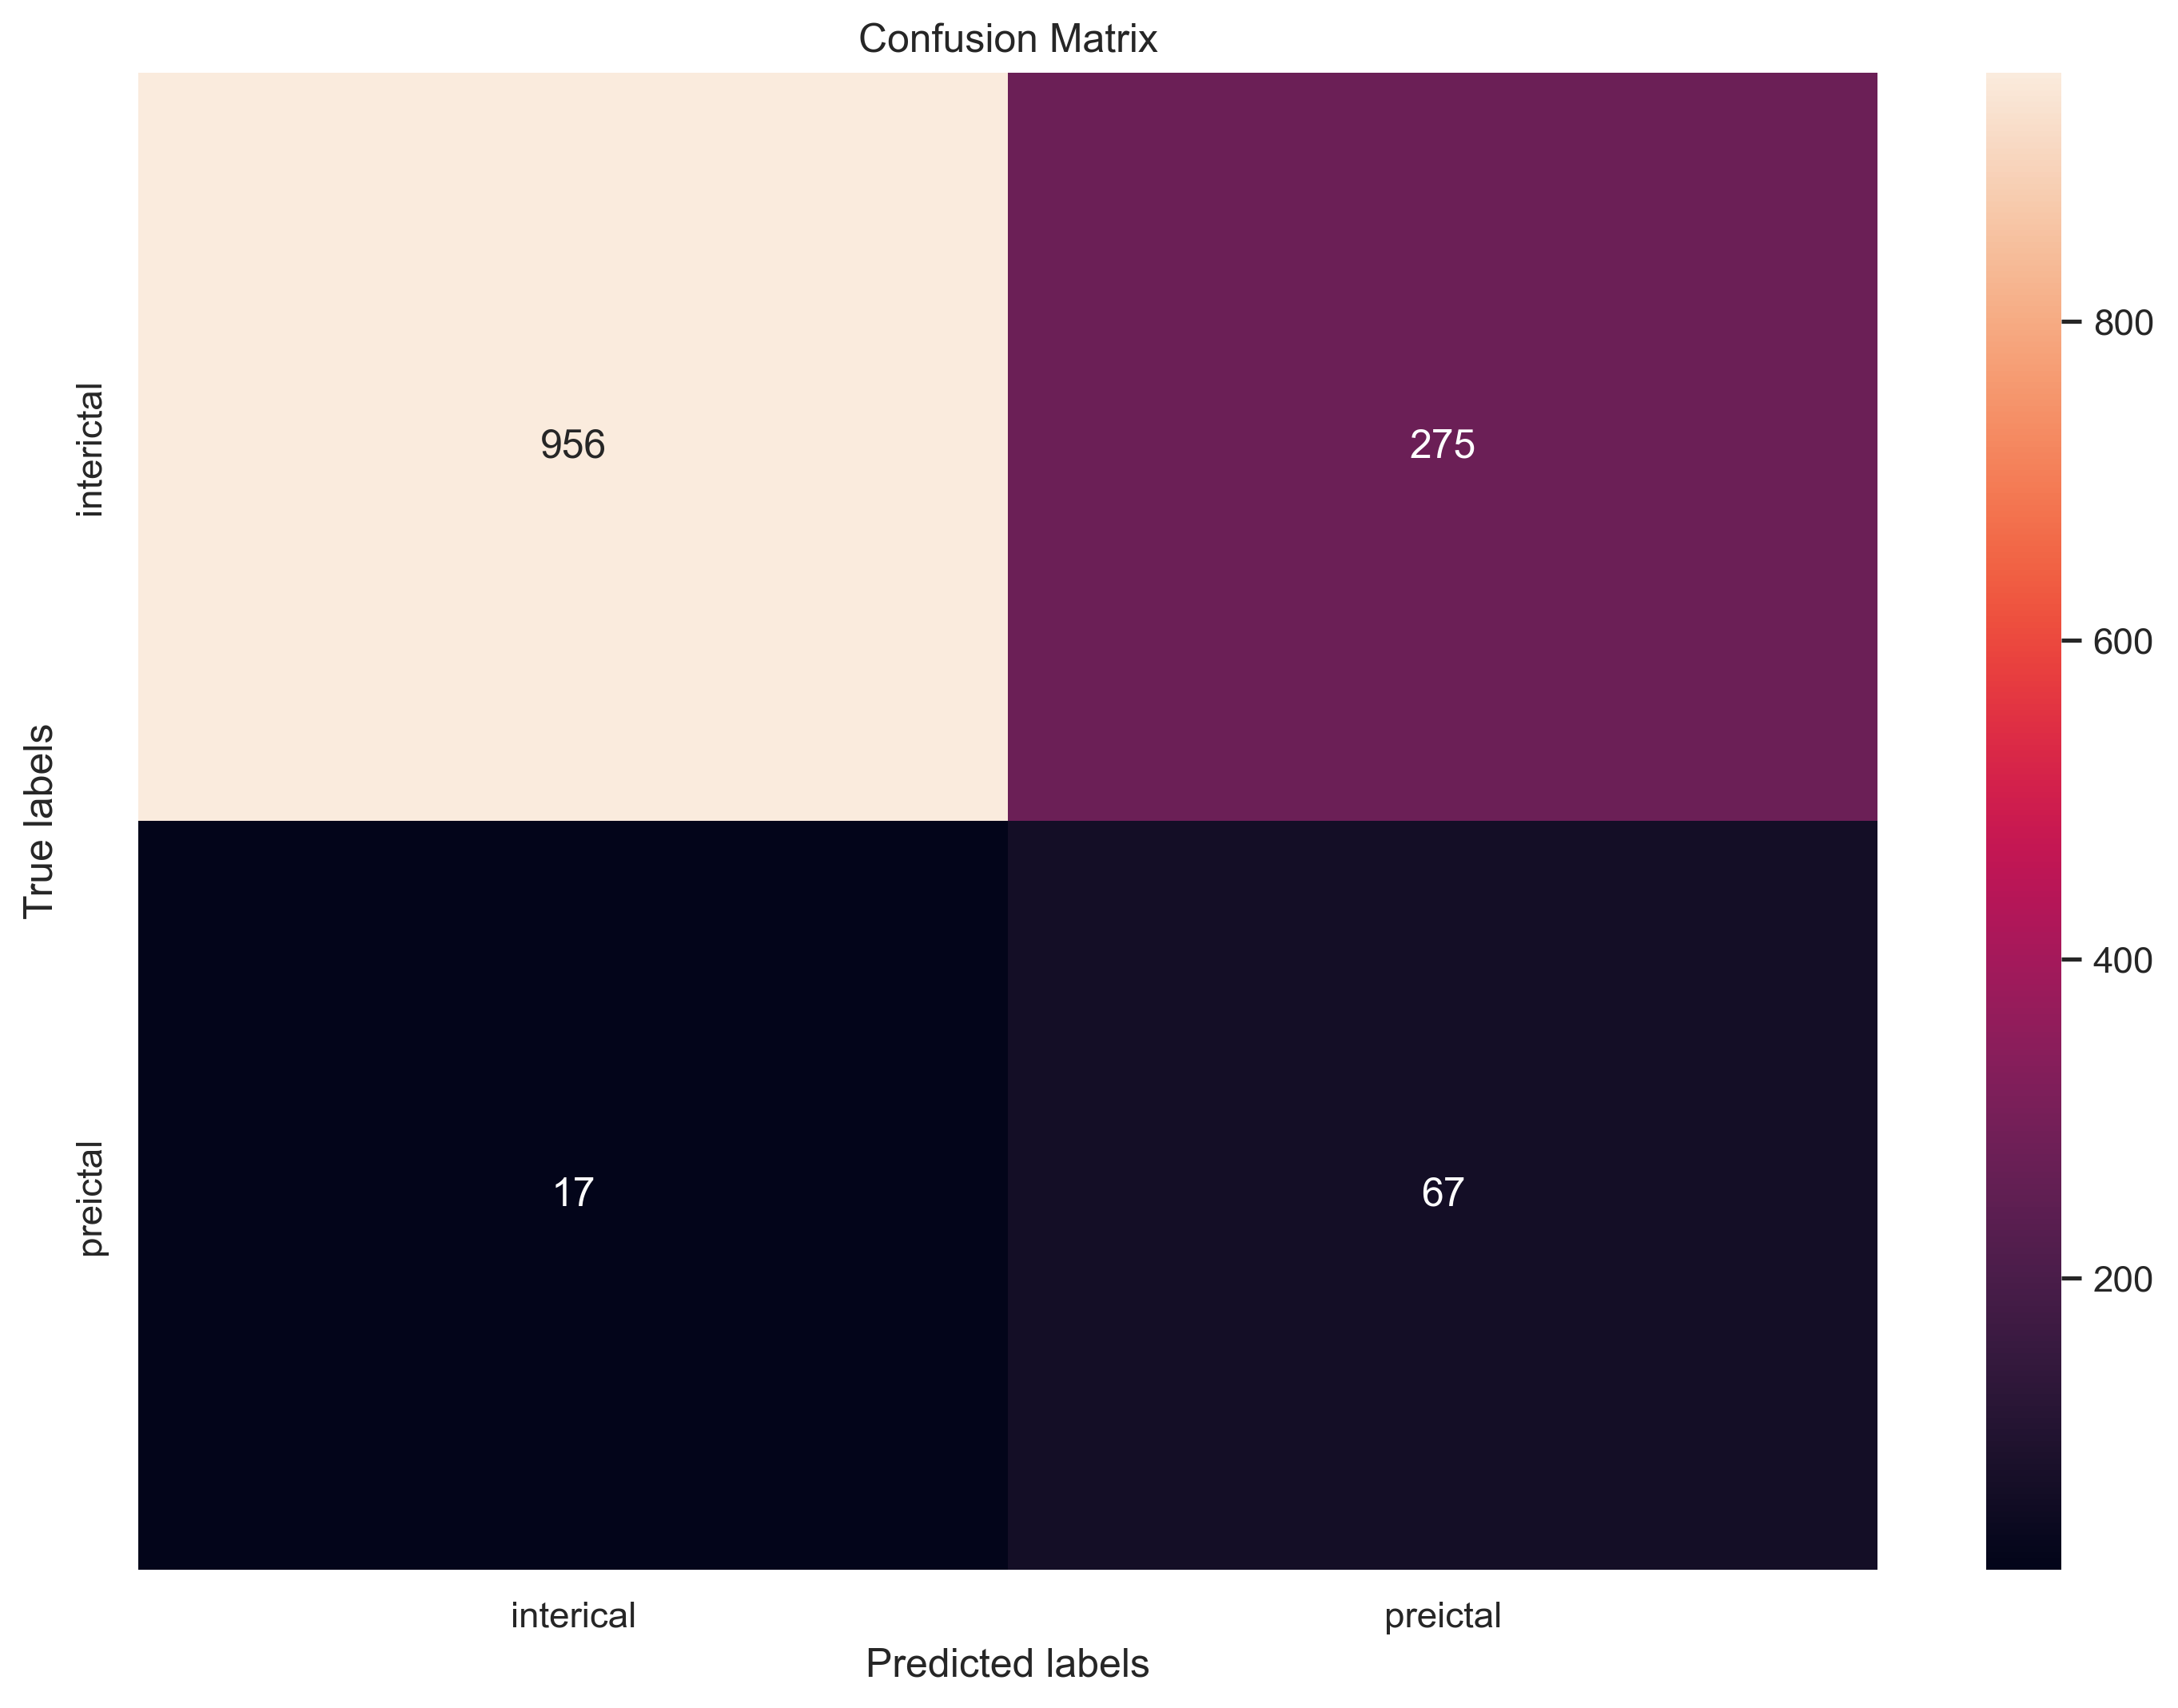

In [16]:
XGBoost = run_test(X_train, y_train, 'XGBoost')